In [52]:
"""
Attendee Community Detection - Part 1
-------------------------------------
This script provides functionality for loading and preprocessing attendee data, 
and preparing it for community detection analysis.

The main goals of this script are:
1. Load data from CSV files
2. Preprocess and clean text fields
3. Convert processed_interests and processed_skills from string to list format
4. Prepare the data for feature extraction in subsequent steps
"""

import pandas as pd
import numpy as np
import ast
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def load_data(attendees_path, event_attendee_path=None):
    """
    Load the attendee data and optionally event-attendee pair data.
    
    Args:
        attendees_path (str): Path to the attendees CSV file
        event_attendee_path (str, optional): Path to the event-attendee pairs CSV file
        
    Returns:
        pd.DataFrame or tuple: Attendees DataFrame, or tuple of (Attendees DataFrame, Event-Attendee DataFrame)
    """
    print(f"Loading attendees data from {attendees_path}")
    attendees_df = pd.read_csv(attendees_path)
    
    # Handle event-attendee pairs if provided
    if event_attendee_path:
        print(f"Loading event-attendee pairs from {event_attendee_path}")
        event_attendee_df = pd.read_csv(event_attendee_path)
        
        # Map attendee IDs (converts 'a123' to 'A123')
        event_attendee_df['attendee_id_mapped'] = event_attendee_df['attendee_id'].str.upper()
        
        return attendees_df, event_attendee_df
    
    return attendees_df

def load_event_data(event_data_path):
    """
    Load event data and create a mapping from event_id to event name.
    
    Args:
        event_data_path (str): Path to the event data CSV file
        
    Returns:
        dict: Mapping from event_id to event name
    """
    print(f"Loading event data from {event_data_path}")
    
    # Load data
    event_data_df = pd.read_csv(event_data_path)
    
    # Standardize column names
    event_data_df.columns = [col.strip().lower() for col in event_data_df.columns]
    
    # Create a mapping from event_id to event name
    event_id_to_name = {}
    for _, row in event_data_df.iterrows():
        event_id_to_name[row['event_id']] = row['event name']
    
    print(f"Loaded {len(event_id_to_name)} event names")
    
    return event_id_to_name

def parse_list_string(s):
    """
    Parse a string representation of a list into an actual list.
    
    Args:
        s (str): String representation of a list, e.g., "['item1', 'item2']"
        
    Returns:
        list: The parsed list of items
    """
    if pd.isna(s) or s == '':
        return []
    
    try:
        # Try using ast.literal_eval for proper parsing
        return ast.literal_eval(s)
    except (SyntaxError, ValueError):
        # Fallback to manual parsing if ast fails
        # Remove brackets, split by comma, and clean up each item
        items = s.strip('[]').split(',')
        return [item.strip().strip("'\"") for item in items if item.strip()]

def preprocess_attendees(df):
    """
    Preprocess the attendees DataFrame.
    
    Args:
        df (pd.DataFrame): The attendees DataFrame
        
    Returns:
        pd.DataFrame: Preprocessed attendees DataFrame
    """
    print("Preprocessing attendees data...")
    
    # Make a copy to avoid modifying the original
    processed_df = df.copy()
    
    # Clean column names (strip whitespace)
    processed_df.columns = processed_df.columns.str.strip()
    
    # Convert the processed_interests and processed_skills from string to list
    processed_df['processed_interests_list'] = processed_df['processed_interests'].apply(parse_list_string)
    processed_df['processed_skills_list'] = processed_df['processed_skills'].apply(parse_list_string)
    
    # Clean and standardize text fields
    text_columns = ['Education', 'Specialization', 'Job_title']
    for col in text_columns:
        # Fill NaN with empty string, convert to lowercase, and strip whitespace
        processed_df[col] = processed_df[col].fillna('').str.lower().str.strip()
    
    print(f"Preprocessing complete. Data shape: {processed_df.shape}")
    
    return processed_df

def analyze_data(df):
    """
    Analyze the preprocessed data to better understand its structure.
    
    Args:
        df (pd.DataFrame): The preprocessed attendees DataFrame
        
    Returns:
        dict: Analysis results
    """
    print("Analyzing attendee data...")
    
    analysis = {
        'total_attendees': len(df),
        'education_counts': df['Education'].value_counts().head(10).to_dict(),
        'specialization_counts': df['Specialization'].value_counts().head(10).to_dict(),
        'job_title_counts': df['Job_title'].value_counts().head(10).to_dict(),
    }
    
    # Count all skills and interests
    all_skills = [skill for skills in df['processed_skills_list'] for skill in skills]
    all_interests = [interest for interests in df['processed_interests_list'] for interest in interests]
    
    analysis['top_skills'] = Counter(all_skills).most_common(15)
    analysis['top_interests'] = Counter(all_interests).most_common(15)
    
    # Print some analysis results
    print(f"Total attendees: {analysis['total_attendees']}")
    print(f"Top 5 education values: {list(analysis['education_counts'].keys())[:5]}")
    print(f"Top 5 specializations: {list(analysis['specialization_counts'].keys())[:5]}")
    print(f"Top 5 job titles: {list(analysis['job_title_counts'].keys())[:5]}")
    print(f"Top 5 skills: {[s[0] for s in analysis['top_skills'][:5]]}")
    print(f"Top 5 interests: {[i[0] for i in analysis['top_interests'][:5]]}")
    
    return analysis

if __name__ == "__main__":
    # Example usage
    attendees_path = r"C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\processed_data.csv"
    event_attendee_path = r"C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\event_attendee_pairs_future.csv"
    event_data_path = r"C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\synthetic_event_data_2025.csv"

    # Load data
    attendees_df, event_attendee_df = load_data(attendees_path, event_attendee_path)
    event_id_to_name = load_event_data(event_data_path)
    # Preprocess attendees data
    processed_df = preprocess_attendees(attendees_df)
    
    # Analyze the preprocessed data
    analysis_results = analyze_data(processed_df)
    
    # Display sample rows to verify preprocessing
    print("\nSample preprocessed data:")
    sample = processed_df.head(2)
    print(sample[['A_ID', 'Education', 'Specialization', 'Job_title']].to_string())
    
    # Display sample of processed lists
    print("\nSample processed interests and skills:")
    for i, row in sample.iterrows():
        print(f"Attendee {row['A_ID']}:")
        print(f"  Interests: {row['processed_interests_list']}")
        print(f"  Skills: {row['processed_skills_list']}")

Loading attendees data from C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\processed_data.csv
Loading event-attendee pairs from C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\event_attendee_pairs_future.csv
Loading event data from C:\Users\Artur\OneDrive\Documentos\GitHub\bagel-hack\synthetic_event_data_2025.csv
Loaded 100 event names
Preprocessing attendees data...
Preprocessing complete. Data shape: (1000, 15)
Analyzing attendee data...
Total attendees: 1000
Top 5 education values: ['b.sc', 'b.tech', 'bachelor of management studies', 'diploma in pharmacy', 'b.com']
Top 5 specializations: ['biotechnology', 'electronics and communication engineering', 'mathematics', 'physics', 'information technology']
Top 5 job titles: ['student (unemployed)', 'teaching', 'software engineer', 'sub editor', 'asst. manager']
Top 5 skills: ['critical thinking', 'communication skills', 'leadership', 'problem solving skills', 'active listening']
Top 5 interests: ['technology', 'teach', 'researc

Extracting features...
Creating TF-IDF vectors for Education and Specialization...
Creating TF-IDF vectors for Job titles...
Creating binary vectors for skills...
Creating binary vectors for interests...
Education/Specialization matrix shape: (1000, 61)
Job title matrix shape: (1000, 64)
Skills matrix shape: (1000, 176)
Interests matrix shape: (1000, 69)
Calculating similarity...
Computing cosine similarities...
Combining similarities with weights: {'edu_spec': 0.4, 'job': 0.3, 'skill': 0.2, 'interest': 0.1}
Similarity matrix shape: (1000, 1000)
Similarity range: [0.0000, 1.0000]
Analyzing similarity distribution...
Similarity statistics:
  Range: [0.0112, 1.0000]
  Mean: 0.1883
  Median: 0.0889
  Suggested thresholds:
    Low density threshold: 0.1465 (75th percentile)
    Medium density threshold: 0.0889 (50th percentile)
    High density threshold: 0.0577 (25th percentile)


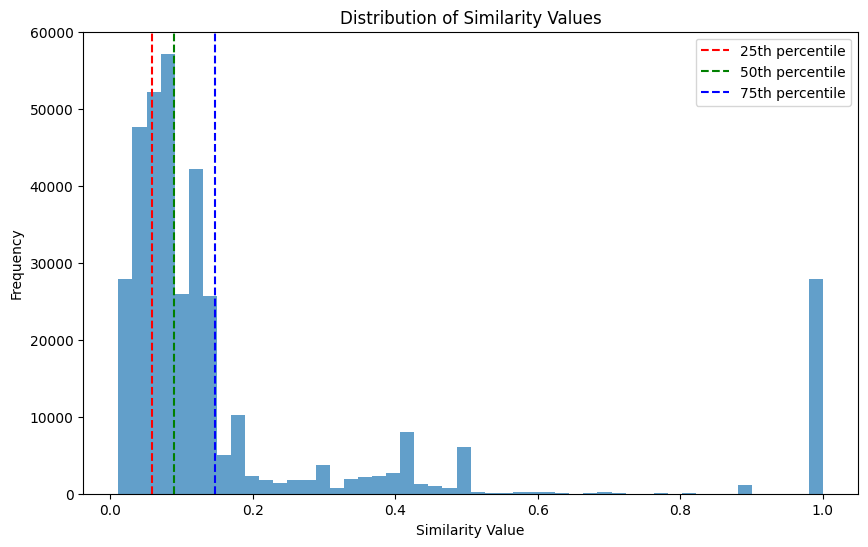

Visualizing similarity matrix...
Sampling 100 attendees for visualization


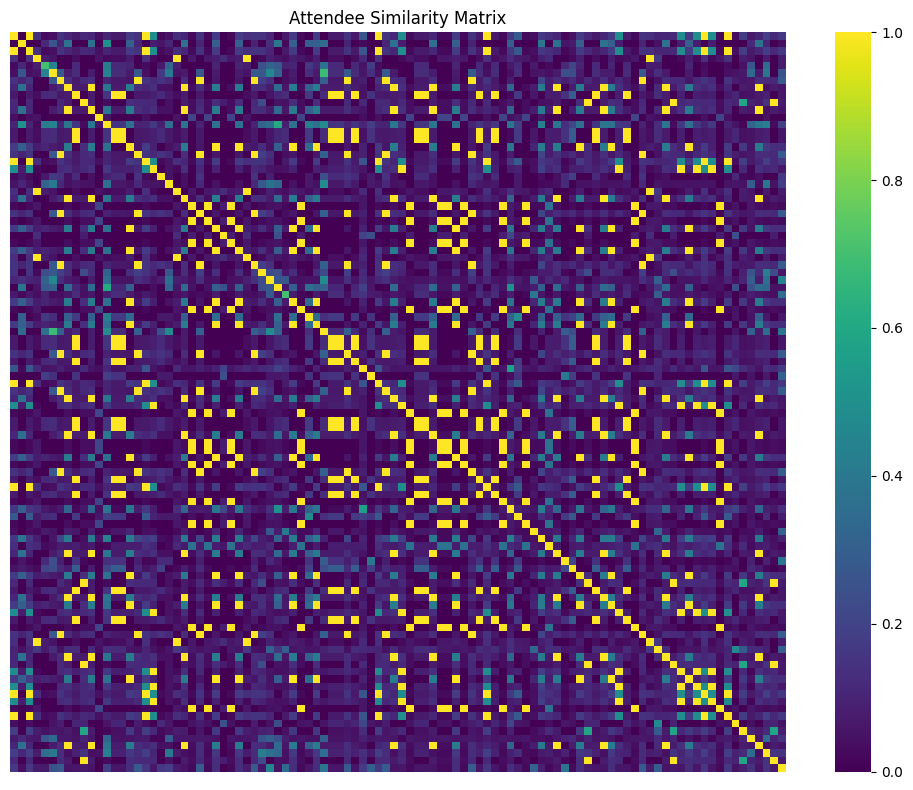

In [53]:
"""
Attendee Community Detection - Part 2
-------------------------------------
This section implements feature extraction and similarity calculation.

Key functions:
1. Extract TF-IDF features from text fields (Education, Specialization, Job_title)
2. Create binary vectors for skills and interests
3. Calculate weighted similarity between attendees based on multiple attributes
4. Visualize and analyze the similarity matrix inline
"""

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def extract_features(df):
    """
    Extract features from the preprocessed attendees data.
    
    Args:
        df (pd.DataFrame): Preprocessed attendees DataFrame
        
    Returns:
        dict: Dictionary containing feature matrices and metadata
    """
    print("Extracting features...")
    
    features = {}
    
    # 1. TF-IDF for Education and Specialization combined (prioritized)
    print("Creating TF-IDF vectors for Education and Specialization...")
    tfidf_edu_spec = TfidfVectorizer(min_df=2, max_features=1000)
    edu_spec_text = df.apply(lambda row: f"{row['Education']} {row['Specialization']}", axis=1)
    features['edu_spec_matrix'] = tfidf_edu_spec.fit_transform(edu_spec_text)
    features['edu_spec_features'] = tfidf_edu_spec.get_feature_names_out()
    
    # 2. TF-IDF for Job title (prioritized)
    print("Creating TF-IDF vectors for Job titles...")
    tfidf_job = TfidfVectorizer(min_df=2, max_features=500)
    features['job_matrix'] = tfidf_job.fit_transform(df['Job_title'])
    features['job_features'] = tfidf_job.get_feature_names_out()
    
    # 3. Binary vectors for skills (secondary)
    print("Creating binary vectors for skills...")
    # Get all unique skills
    all_skills = sorted(set(skill for skills in df['processed_skills_list'] for skill in skills))
    features['all_skills'] = all_skills
    
    # Create binary vectors (1 if attendee has skill, 0 otherwise)
    skill_vectors = []
    for skills in df['processed_skills_list']:
        skill_vec = [1 if skill in skills else 0 for skill in all_skills]
        skill_vectors.append(skill_vec)
    features['skill_matrix'] = np.array(skill_vectors)
    
    # 4. Binary vectors for interests (secondary)
    print("Creating binary vectors for interests...")
    # Get all unique interests
    all_interests = sorted(set(interest for interests in df['processed_interests_list'] for interest in interests))
    features['all_interests'] = all_interests
    
    # Create binary vectors (1 if attendee has interest, 0 otherwise)
    interest_vectors = []
    for interests in df['processed_interests_list']:
        interest_vec = [1 if interest in interests else 0 for interest in all_interests]
        interest_vectors.append(interest_vec)
    features['interest_matrix'] = np.array(interest_vectors)
    
    # Print feature dimensions
    print(f"Education/Specialization matrix shape: {features['edu_spec_matrix'].shape}")
    print(f"Job title matrix shape: {features['job_matrix'].shape}")
    print(f"Skills matrix shape: {features['skill_matrix'].shape}")
    print(f"Interests matrix shape: {features['interest_matrix'].shape}")
    
    return features

def calculate_similarity(features, weights=None):
    """
    Calculate weighted similarity between attendees based on multiple attributes.
    
    Args:
        features (dict): Feature matrices extracted from attendees data
        weights (dict, optional): Weights for each feature type. 
                                 Defaults to prioritizing academic background and job.
    
    Returns:
        numpy.ndarray: Weighted similarity matrix
    """
    print("Calculating similarity...")
    
    # Default weights prioritize academic background and job title
    if weights is None:
        weights = {
            'edu_spec': 0.4,  # Education and Specialization (prioritized)
            'job': 0.3,       # Job title (prioritized)
            'skill': 0.2,     # Skills (secondary)
            'interest': 0.1   # Interests (secondary)
        }
    
    # Calculate cosine similarity for each feature type
    print("Computing cosine similarities...")
    edu_spec_sim = cosine_similarity(features['edu_spec_matrix'])
    job_sim = cosine_similarity(features['job_matrix'])
    skill_sim = cosine_similarity(features['skill_matrix'])
    interest_sim = cosine_similarity(features['interest_matrix'])
    
    # Combine similarities using weights
    print(f"Combining similarities with weights: {weights}")
    combined_sim = (
        weights['edu_spec'] * edu_spec_sim +
        weights['job'] * job_sim +
        weights['skill'] * skill_sim +
        weights['interest'] * interest_sim
    )
    
    # Normalize to [0, 1]
    max_sim = np.max(combined_sim)
    if max_sim > 0:
        combined_sim = combined_sim / max_sim
    
    print(f"Similarity matrix shape: {combined_sim.shape}")
    print(f"Similarity range: [{np.min(combined_sim):.4f}, {np.max(combined_sim):.4f}]")
    
    return combined_sim

def visualize_similarity_matrix(similarity_matrix):
    """
    Visualize the similarity matrix as a heatmap.
    
    Args:
        similarity_matrix (numpy.ndarray): The similarity matrix
    """
    print("Visualizing similarity matrix...")
    
    # If matrix is too large, sample it
    if similarity_matrix.shape[0] > 100:
        indices = np.random.choice(similarity_matrix.shape[0], 100, replace=False)
        sampled_matrix = similarity_matrix[np.ix_(indices, indices)]
        print(f"Sampling {len(indices)} attendees for visualization")
    else:
        sampled_matrix = similarity_matrix
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sampled_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title('Attendee Similarity Matrix')
    plt.tight_layout()
    plt.show()

def analyze_similarity(similarity_matrix):
    """
    Analyze the similarity matrix to help determine appropriate threshold values.
    
    Args:
        similarity_matrix (numpy.ndarray): The similarity matrix
        
    Returns:
        dict: Analysis of similarity values
    """
    print("Analyzing similarity distribution...")
    
    # Extract upper triangle values (excluding diagonal)
    n = similarity_matrix.shape[0]
    upper_triangle = np.triu(similarity_matrix, k=1).flatten()
    upper_triangle = upper_triangle[upper_triangle > 0]  # Only consider non-zero similarities
    
    # Calculate distribution statistics
    analysis = {
        'min': np.min(upper_triangle),
        'max': np.max(upper_triangle),
        'mean': np.mean(upper_triangle),
        'median': np.median(upper_triangle),
        'percentiles': {
            '10th': np.percentile(upper_triangle, 10),
            '25th': np.percentile(upper_triangle, 25),
            '50th': np.percentile(upper_triangle, 50),
            '75th': np.percentile(upper_triangle, 75),
            '90th': np.percentile(upper_triangle, 90),
            '95th': np.percentile(upper_triangle, 95),
        }
    }
    
    # Print analysis
    print(f"Similarity statistics:")
    print(f"  Range: [{analysis['min']:.4f}, {analysis['max']:.4f}]")
    print(f"  Mean: {analysis['mean']:.4f}")
    print(f"  Median: {analysis['median']:.4f}")
    print(f"  Suggested thresholds:")
    
    # Suggest thresholds based on percentiles
    suggested_thresholds = [
        analysis['percentiles']['25th'],
        analysis['percentiles']['50th'],
        analysis['percentiles']['75th']
    ]
    
    print(f"    Low density threshold: {suggested_thresholds[2]:.4f} (75th percentile)")
    print(f"    Medium density threshold: {suggested_thresholds[1]:.4f} (50th percentile)")
    print(f"    High density threshold: {suggested_thresholds[0]:.4f} (25th percentile)")
    
    # Visualize distribution
    plt.figure(figsize=(10, 6))
    plt.hist(upper_triangle, bins=50, alpha=0.7)
    plt.axvline(suggested_thresholds[0], color='r', linestyle='--', label='25th percentile')
    plt.axvline(suggested_thresholds[1], color='g', linestyle='--', label='50th percentile')
    plt.axvline(suggested_thresholds[2], color='b', linestyle='--', label='75th percentile')
    plt.xlabel('Similarity Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similarity Values')
    plt.legend()
    plt.show()
    
    return analysis


# Extract features from processed data
features = extract_features(processed_df)

# Calculate similarity with customized weights
similarity_weights = {
    'edu_spec': 0.4,  # Education and Specialization
    'job': 0.3,       # Job title
    'skill': 0.2,     # Skills
    'interest': 0.1   # Interests
}
similarity_matrix = calculate_similarity(features, similarity_weights)

# Analyze similarity distribution to choose threshold
similarity_analysis = analyze_similarity(similarity_matrix)

# Visualize similarity matrix
visualize_similarity_matrix(similarity_matrix)

Building graph with similarity threshold: 0.15
Graph construction completed in 0.46 seconds
Graph has 1000 nodes and 85798 edges
Graph density: 0.1718
Mean node degree: 171.60
Graph is connected
Detecting communities using louvain algorithm...
Community detection completed in 1.90 seconds
Detected 7 communities
Community size statistics:
  Min: 82
  Max: 230
  Mean: 142.86
Top 5 largest communities:
  Community 5: 230 members
  Community 2: 191 members
  Community 4: 171 members
  Community 3: 122 members
  Community 6: 116 members
Analyzing detected communities...

Community 0 (88 members):
  Top education: ['b.sc', 'master of journalism', 'm.sc']
  Top specialization: ['physics', 'science', 'econamics']
  Top jobs: ['sub editor', 'teaching', 'software engineernior editor']
  Common skills: ['critical thinking', 'gathering information', 'artistic', 'creative skills', 'analytical skills']
  Common interests: ['content writing', 'news coverage', 'social justice', 'govt. job', 'research'

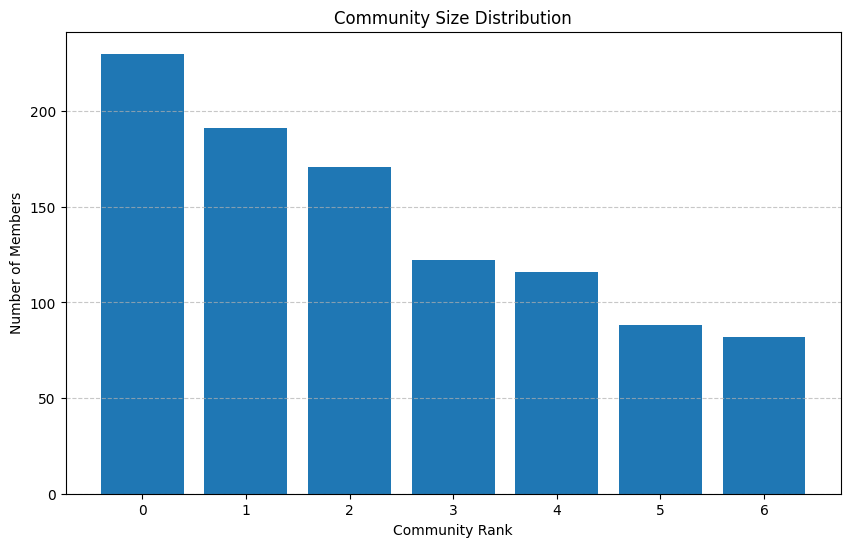


Generated community labels:
  Community 0: Tech Editor Sub
  Community 1: Healthcare Pharmacy Medical
  Community 2: Tech Engineering Civil
  Community 3: Business Business Tele
  Community 4: Science Scientist Manager
  Community 5: Education Student Student Unemployed
  Community 6: Tech Engineer Software Engineer
Visualizing communities...
Computing layout...


C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\1299676568.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(community_ids))


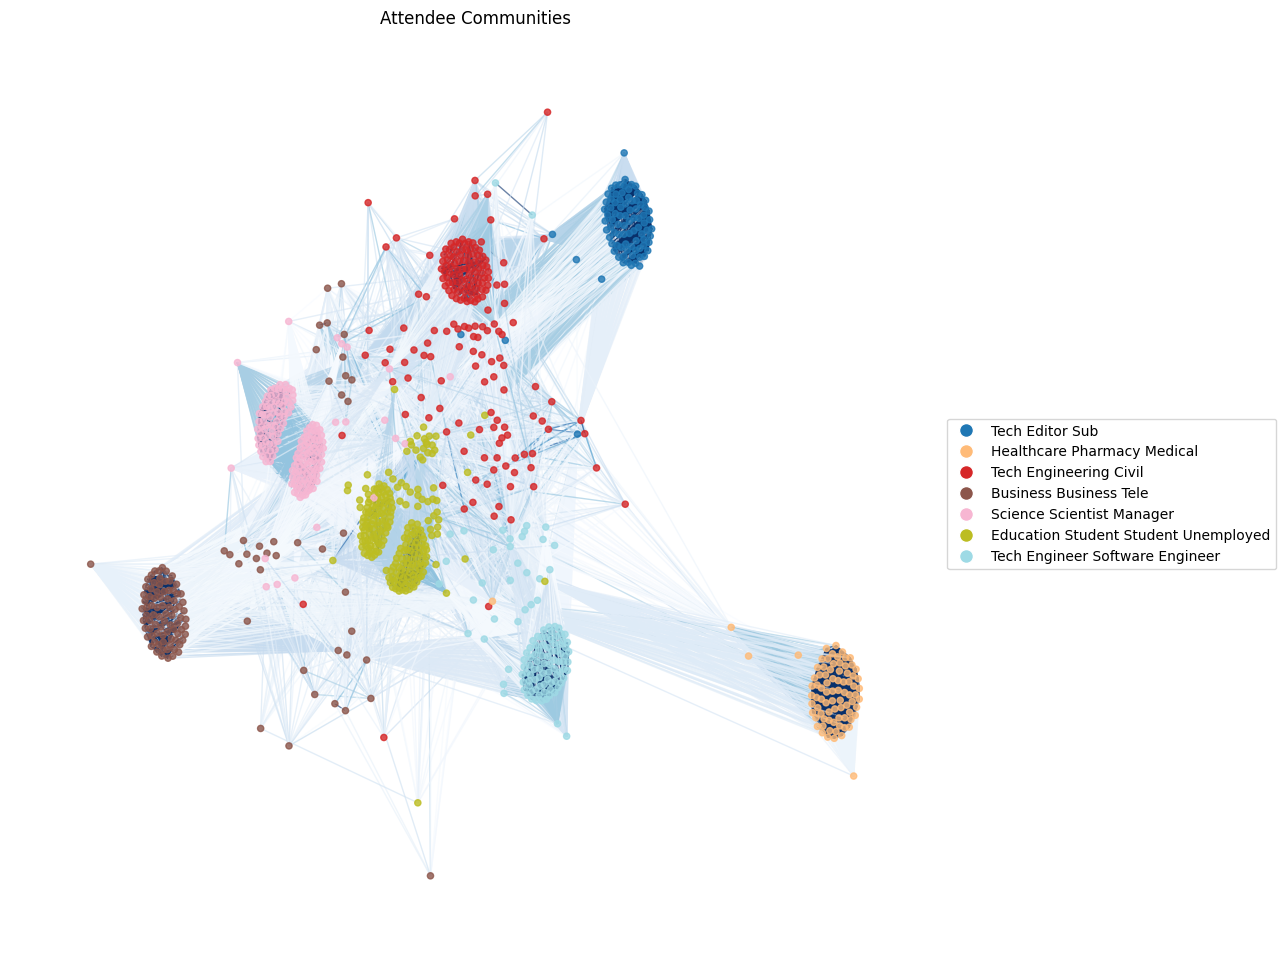

In [54]:
"""
Attendee Community Detection - Part 3
-------------------------------------
This section implements graph construction and community detection.

Key functions:
1. Build a weighted graph where nodes are attendees and edges represent similarity
2. Apply community detection algorithms (Louvain, Label Propagation)
3. Analyze and visualize the resulting communities
"""

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter
import community as community_louvain  # python-louvain package
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

def build_graph(similarity_matrix, threshold=0.1, weighted=True):
    """
    Build a graph from the similarity matrix.
    
    Args:
        similarity_matrix (numpy.ndarray): Similarity matrix between attendees
        threshold (float): Minimum similarity value to create an edge
        weighted (bool): Whether to create a weighted graph
        
    Returns:
        networkx.Graph: Graph representation of attendees network
    """
    print(f"Building graph with similarity threshold: {threshold}")
    start_time = time.time()
    
    # Create empty graph
    G = nx.Graph()
    
    # Add nodes
    n_attendees = similarity_matrix.shape[0]
    G.add_nodes_from(range(n_attendees))
    
    # Add edges
    edge_count = 0
    
    # Iterate through upper triangle of similarity matrix
    for i in range(n_attendees):
        for j in range(i+1, n_attendees):
            similarity = similarity_matrix[i, j]
            if similarity > threshold:
                if weighted:
                    G.add_edge(i, j, weight=float(similarity))
                else:
                    G.add_edge(i, j)
                edge_count += 1
    
    duration = time.time() - start_time
    
    # Report on graph construction
    print(f"Graph construction completed in {duration:.2f} seconds")
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Calculate graph density
    density = nx.density(G)
    print(f"Graph density: {density:.4f}")
    
    # Calculate mean degree
    degrees = [d for _, d in G.degree()]
    mean_degree = sum(degrees) / len(degrees) if degrees else 0
    print(f"Mean node degree: {mean_degree:.2f}")
    
    # Check if graph is connected
    if nx.is_connected(G):
        print("Graph is connected")
    else:
        components = list(nx.connected_components(G))
        print(f"Graph is not connected. Found {len(components)} connected components")
        print(f"Largest component has {len(max(components, key=len))} nodes")
    
    return G

def detect_communities(G, algorithm='louvain', seed=None):
    """
    Detect communities in the graph using various algorithms.
    
    Args:
        G (networkx.Graph): Graph representation of attendees network
        algorithm (str): Community detection algorithm to use
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        dict: Mapping of node indices to community IDs
    """
    print(f"Detecting communities using {algorithm} algorithm...")
    start_time = time.time()
    
    if algorithm == 'louvain':
        # Louvain method for community detection
        partition = community_louvain.best_partition(G, random_state=seed)
        
    elif algorithm == 'label_propagation':
        # Label Propagation algorithm
        communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
                
    elif algorithm == 'greedy_modularity':
        # Greedy modularity-based algorithm
        communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")
    
    duration = time.time() - start_time
    print(f"Community detection completed in {duration:.2f} seconds")
    
    # Count communities
    community_counts = Counter(partition.values())
    print(f"Detected {len(community_counts)} communities")
    
    # Report size statistics
    community_sizes = list(community_counts.values())
    print(f"Community size statistics:")
    print(f"  Min: {min(community_sizes)}")
    print(f"  Max: {max(community_sizes)}")
    print(f"  Mean: {sum(community_sizes) / len(community_sizes):.2f}")
    
    # List the largest communities
    top_communities = community_counts.most_common(5)
    print(f"Top 5 largest communities:")
    for community_id, size in top_communities:
        print(f"  Community {community_id}: {size} members")
    
    return partition

def visualize_communities(G, communities, community_labels=None, node_size=20, node_alpha=0.8, edge_alpha=0.6, max_nodes=1000):
    """
    Visualize communities in the graph with descriptive labels.
    
    Args:
        G (networkx.Graph): Graph representation of attendees network
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        node_size (int): Size of nodes in visualization
        node_alpha (float): Transparency of nodes
        edge_alpha (float): Transparency of edges
        max_nodes (int): Maximum number of nodes to visualize
    """
    print("Visualizing communities...")
    
    # Sample graph if it's too large
    if G.number_of_nodes() > max_nodes:
        print(f"Graph is too large ({G.number_of_nodes()} nodes). Sampling {max_nodes} nodes for visualization.")
        
        # Try to select connected nodes by using a subgraph of the largest component
        components = list(nx.connected_components(G))
        largest_component = max(components, key=len)
        
        # If largest component is still too large, sample from it
        if len(largest_component) > max_nodes:
            sampled_nodes = list(largest_component)[:max_nodes]
        else:
            sampled_nodes = list(largest_component)
        
        G = G.subgraph(sampled_nodes)
        communities = {node: communities[node] for node in sampled_nodes if node in communities}
    
    # Get unique community IDs
    community_ids = sorted(set(communities.values()))
    
    # Create a colormap
    colormap = cm.get_cmap('tab20', len(community_ids))
    
    # Map community IDs to colors
    color_map = {community_id: colormap(i) for i, community_id in enumerate(community_ids)}
    
    # Assign colors to nodes based on their community
    node_colors = [color_map[communities[node]] for node in G.nodes()]
    
    # Create spring layout for visualization
    print("Computing layout...")
    pos = nx.spring_layout(G, k=0.15, seed=42)
    
    # Create figure
    plt.figure(figsize=(12, 12))
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, 
        node_color=node_colors,
        node_size=node_size,
        alpha=node_alpha
    )
    
    # Draw edges with transparency based on weight if available
    if G.edges and 'weight' in G.edges[list(G.edges())[0]]:
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw_networkx_edges(
            G, pos,
            width=1,
            alpha=edge_alpha,
            edge_color=edge_weights,
            edge_cmap=plt.cm.Blues
        )
    else:
        nx.draw_networkx_edges(
            G, pos,
            width=1,
            alpha=edge_alpha
        )
    
    # Add legend for communities
    # Create a proxy artist for each community color
    proxy_artists = []
    for i, comm_id in enumerate(sorted(color_map.keys())[:10]):  # Show only top 10 communities
        if community_labels and comm_id in community_labels:
            label = community_labels[comm_id]
        else:
            label = f"Community {comm_id}"
        
        proxy_artists.append(plt.Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor=color_map[comm_id], 
                                      markersize=10, label=label))
    
    plt.legend(handles=proxy_artists, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Attendee Communities")
    plt.axis('off')
    plt.show()
    
def analyze_communities(communities, attendees_df):
    """
    Analyze the detected communities to identify common characteristics.
    
    Args:
        communities (dict): Mapping of node indices to community IDs
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        
    Returns:
        tuple: Community analysis dictionary and DataFrame with community assignments
    """
    print("Analyzing detected communities...")
    
    # Convert communities dict to pandas Series
    community_series = pd.Series(communities)
    
    # Add community labels to DataFrame
    attendees_with_communities = attendees_df.copy()
    attendees_with_communities['community_id'] = community_series
    
    # Get unique community IDs
    community_ids = sorted(set(communities.values()))
    
    # Count sizes of each community
    community_counts = Counter(communities.values())
    community_sizes = list(community_counts.values())  # Define community_sizes here
    
    # Initialize community analysis dictionary
    community_analysis = {}
    
    # Analyze each community
    for community_id in community_ids:
        # Get attendees in this community
        community_members = attendees_with_communities[
            attendees_with_communities['community_id'] == community_id
        ]
        
        # Skip very small communities
        if len(community_members) < 3:
            continue
        
        # Count education values
        edu_counts = community_members['Education'].value_counts().head(5)
        top_edu = [(edu, count) for edu, count in edu_counts.items()]
        
        # Count specialization values
        spec_counts = community_members['Specialization'].value_counts().head(5)
        top_spec = [(spec, count) for spec, count in spec_counts.items()]
        
        # Count job titles
        job_counts = community_members['Job_title'].value_counts().head(5)
        top_jobs = [(job, count) for job, count in job_counts.items()]
        
        # Analyze skills
        all_skills = []
        for skills in community_members['processed_skills_list']:
            all_skills.extend(skills)
        common_skills = Counter(all_skills).most_common(10)
        
        # Analyze interests
        all_interests = []
        for interests in community_members['processed_interests_list']:
            all_interests.extend(interests)
        common_interests = Counter(all_interests).most_common(10)
        
        # Store community analysis
        community_analysis[community_id] = {
            'size': len(community_members),
            'top_education': top_edu,
            'top_specialization': top_spec,
            'top_jobs': top_jobs,
            'common_skills': common_skills,
            'common_interests': common_interests
        }
        
        # Print summary for this community
        print(f"\nCommunity {community_id} ({len(community_members)} members):")
        print(f"  Top education: {[e[0] for e in top_edu[:3]]}")
        print(f"  Top specialization: {[s[0] for s in top_spec[:3]]}")
        print(f"  Top jobs: {[j[0] for j in top_jobs[:3]]}")
        print(f"  Common skills: {[s[0] for s in common_skills[:5]]}")
        print(f"  Common interests: {[i[0] for i in common_interests[:5]]}")
    
    # Add community information to DataFrame
    attendees_with_communities['community_size'] = attendees_with_communities['community_id'].map(
        {comm_id: analysis['size'] for comm_id, analysis in community_analysis.items()}
    )
    
    # Plot community size distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(community_sizes)), sorted(community_sizes, reverse=True))
    plt.xlabel('Community Rank')
    plt.ylabel('Number of Members')
    plt.title('Community Size Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return community_analysis, attendees_with_communities

def generate_community_labels_lda(community_analysis, num_topics=1, num_words=3):
    """
    Generate descriptive labels for each community using LDA topic modeling.
    
    Args:
        community_analysis (dict): Analysis of communities with their characteristics
        num_topics (int): Number of topics to extract per community
        num_words (int): Number of top words to include in the label
        
    Returns:
        dict: Mapping of community IDs to descriptive labels
    """
    labels = {}
    
    # Define domain areas for better labeling
    domain_areas = {
        'tech': ["software", "engineer", "python", "sql", "programming", "technology", "it", "computer"],
        'business': ["business", "management", "sales", "marketing", "consultant", "entrepreneur"],
        'healthcare': ["medical", "healthcare", "pharmacy", "doctor", "hospital", "medicine"],
        'education': ["teaching", "teacher", "professor", "education", "student", "academic"],
        'media': ["journalism", "editor", "news", "content", "writing", "media"],
        'science': ["research", "scientist", "laboratory", "biology", "chemistry", "physics"]
    }
    
    for community_id, analysis in community_analysis.items():
        # Collect all textual information from the community
        texts = []
        
        # Add education info
        for edu, _ in analysis['top_education']:
            texts.append(edu)
            
        # Add specialization info
        for spec, _ in analysis['top_specialization']:
            texts.append(spec)
            
        # Add job titles
        for job, _ in analysis['top_jobs']:
            texts.append(job)
            
        # Add skills
        for skill, _ in analysis['common_skills']:
            texts.append(skill)
            
        # Add interests
        for interest, _ in analysis['common_interests']:
            texts.append(interest)
            
        # Create a single document for this community
        document = " ".join(texts)
        
        # Create a count vectorizer
        vectorizer = CountVectorizer(
            stop_words='english', 
            max_features=100,
            token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  # Words with at least 2 letters
        )
        
        # Transform document to vector
        X = vectorizer.fit_transform([document])
        
        # Get feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Apply LDA
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            random_state=42,
            max_iter=5
        )
        
        # Fit LDA
        lda.fit(X)
        
        # Get top words for the topic
        topic_words = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-num_words-1:-1]
            top_words = [feature_names[i] for i in top_words_idx]
            topic_words.extend(top_words)
        
        # Check which domain the words belong to
        domain_counts = {domain: 0 for domain in domain_areas}
        for word in topic_words:
            for domain, keywords in domain_areas.items():
                if word in keywords or any(kw in word for kw in keywords):
                    domain_counts[domain] += 1
        
        # Find the dominant domain
        if any(domain_counts.values()):
            dominant_domain = max(domain_counts.items(), key=lambda x: x[1])[0]
        else:
            dominant_domain = None
        
        # Create a label using the top words and domain information
        if dominant_domain:
            # Capitalize the words and join with spaces
            capitalized_words = [word.capitalize() for word in topic_words]
            topic_label = " ".join(capitalized_words)
            labels[community_id] = f"{dominant_domain.capitalize()} {topic_label}"
        else:
            # Just use the topic words
            capitalized_words = [word.capitalize() for word in topic_words]
            labels[community_id] = " ".join(capitalized_words)
    
    return labels

def generate_community_labels_tfidf(community_analysis, num_words=2):
    """
    Generate descriptive labels for each community using TF-IDF to find 
    the most distinctive terms for each community.
    
    Args:
        community_analysis (dict): Analysis of communities with their characteristics
        num_words (int): Number of top words to include in the label
        
    Returns:
        dict: Mapping of community IDs to descriptive labels
    """
    labels = {}
    
    # Define domain areas for better labeling
    domain_areas = {
        'tech': ["software", "engineer", "python", "sql", "programming", "technology", "it", "computer"],
        'business': ["business", "management", "sales", "marketing", "consultant", "entrepreneur"],
        'healthcare': ["medical", "healthcare", "pharmacy", "doctor", "hospital", "medicine"],
        'education': ["teaching", "teacher", "professor", "education", "student", "academic"],
        'media': ["journalism", "editor", "news", "content", "writing", "media"],
        'science': ["research", "scientist", "laboratory", "biology", "chemistry", "physics"]
    }
    
    # Create a document for each community
    community_docs = {}
    for community_id, analysis in community_analysis.items():
        texts = []
        
        # Add education info (with higher weight by repeating)
        for edu, count in analysis['top_education']:
            texts.extend([edu] * 3)  # Weight education more
            
        # Add specialization info (with higher weight)
        for spec, count in analysis['top_specialization']:
            texts.extend([spec] * 3)  # Weight specialization more
            
        # Add job titles (with highest weight)
        for job, count in analysis['top_jobs']:
            texts.extend([job] * 4)  # Weight jobs even more
            
        # Add skills
        for skill, count in analysis['common_skills']:
            texts.append(skill)
            
        # Add interests
        for interest, count in analysis['common_interests']:
            texts.append(interest)
            
        # Create a single document for this community
        community_docs[community_id] = " ".join(texts)
    
    # Apply TF-IDF to find distinctive terms for each community
    tfidf_vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=200,
        ngram_range=(1, 2),  # Allow 1-2 word phrases
        token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b'  # Words with at least 2 letters
    )
    
    # Transform all documents
    tfidf_matrix = tfidf_vectorizer.fit_transform(list(community_docs.values()))
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # For each community, find the most distinctive terms
    community_ids = list(community_docs.keys())
    for i, community_id in enumerate(community_ids):
        # Get the TF-IDF scores for this document
        tfidf_scores = tfidf_matrix[i].toarray()[0]
        
        # Sort terms by TF-IDF score
        sorted_indices = tfidf_scores.argsort()[::-1]
        
        # Get top terms
        top_terms = []
        for idx in sorted_indices[:10]:  # Consider top 10 terms initially
            term = feature_names[idx]
            if len(term.split()) <= 2:  # Only include terms with 1-2 words
                top_terms.append(term)
            if len(top_terms) >= num_words:
                break
                
        # Determine domain
        domain_counts = {domain: 0 for domain in domain_areas}
        for term in top_terms:
            for domain, keywords in domain_areas.items():
                if any(kw in term for kw in keywords):
                    domain_counts[domain] += 1
        
        # If a dominant domain is found, use it
        if any(domain_counts.values()):
            dominant_domain = max(domain_counts.items(), key=lambda x: x[1])[0]
            domain_prefix = f"{dominant_domain.capitalize()} "
        else:
            # Look at the job titles directly
            for job, _ in community_analysis[community_id]['top_jobs'][:2]:
                for domain, keywords in domain_areas.items():
                    if any(kw in job for kw in keywords):
                        domain_prefix = f"{domain.capitalize()} "
                        break
                else:
                    continue
                break
            else:
                domain_prefix = ""
        
        # Create label from top terms
        top_terms_formatted = [term.title() for term in top_terms[:num_words]]
        term_part = " ".join(top_terms_formatted)
        
        # Final label
        labels[community_id] = f"{domain_prefix}{term_part}"
    
    return labels

# 1. Build graph from similarity matrix
similarity_threshold = 0.15  # Use threshold from similarity analysis
G = build_graph(similarity_matrix, threshold=similarity_threshold)

# 2. Detect communities
communities = detect_communities(G, algorithm='louvain')

# 3. Analyze communities
community_analysis, attendees_with_communities = analyze_communities(communities, processed_df)

# 4. Generate community labels using LDA
#community_labels = generate_community_labels_lda(community_analysis, num_topics=1, num_words=2)
community_labels = generate_community_labels_tfidf(community_analysis, num_words=2)

# Print the generated labels
print("\nGenerated community labels:")
for community_id, label in community_labels.items():
    print(f"  Community {community_id}: {label}")

# 5. Visualize communities with labels
visualize_communities(G, communities, community_labels)

Loading event-attendee pairs from event_attendee_pairs_future.csv
Found 100 unique events and 751 unique attendees
Total event-attendee pairs: 1298


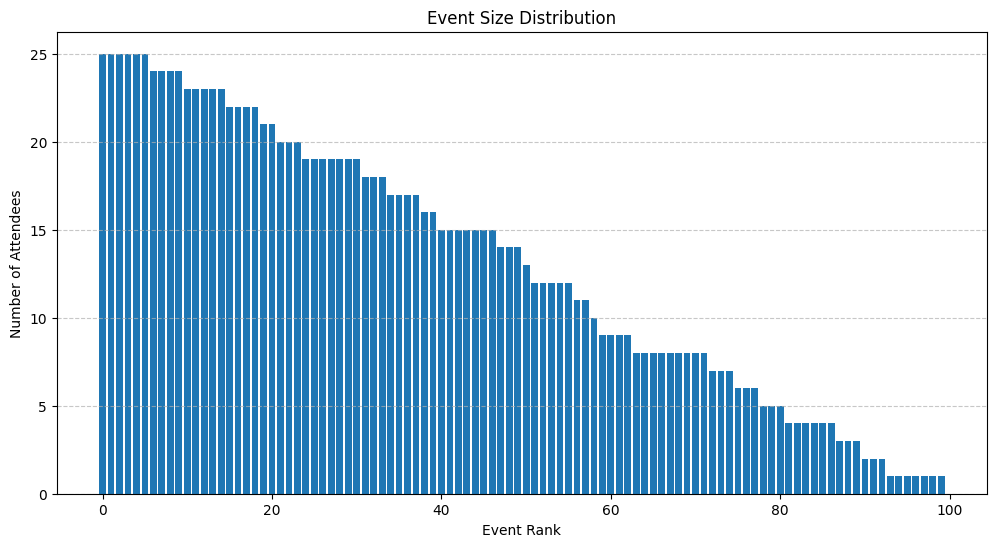

Event size statistics:
  Min: 1 attendees
  Max: 25 attendees
  Mean: 12.98 attendees
  Median: 13.5 attendees
Creating event-attendee-community mappings...
Created mappings for 100 events
Events with most diverse community representation:
  Event e110: 7 different communities
  Event e111: 7 different communities
  Event e112: 7 different communities
  Event e113: 7 different communities
  Event e114: 7 different communities


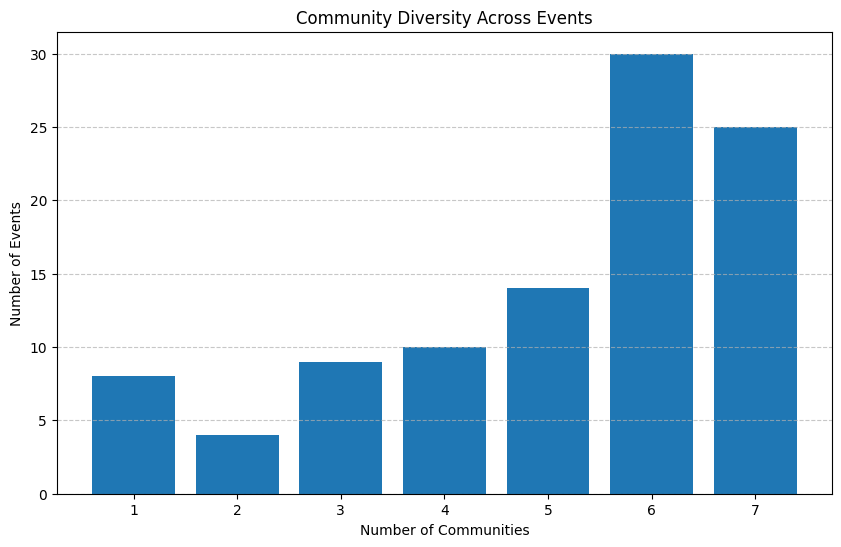

Creating event-specific subgraphs...
Event e101: 17 nodes, 16 edges
Event e102: 1 nodes, 0 edges
Event e103: 5 nodes, 1 edges
Event e104: 2 nodes, 0 edges
Event e105: 8 nodes, 4 edges
Event e106: 24 nodes, 48 edges
Event e107: 19 nodes, 61 edges
Event e108: 5 nodes, 0 edges
Event e109: 25 nodes, 84 edges
Event e110: 25 nodes, 46 edges
Event e111: 20 nodes, 30 edges
Event e112: 13 nodes, 8 edges
Event e113: 19 nodes, 32 edges
Event e114: 25 nodes, 62 edges
Event e115: 8 nodes, 10 edges
Event e116: 10 nodes, 4 edges
Event e117: 23 nodes, 42 edges
Event e118: 15 nodes, 16 edges
Event e119: 24 nodes, 46 edges
Event e120: 8 nodes, 5 edges
Event e121: 4 nodes, 1 edges
Event e122: 15 nodes, 18 edges
Event e123: 8 nodes, 2 edges
Event e124: 12 nodes, 5 edges
Event e125: 23 nodes, 39 edges
Event e126: 19 nodes, 23 edges
Event e127: 12 nodes, 14 edges
Event e128: 15 nodes, 14 edges
Event e129: 11 nodes, 9 edges
Event e130: 18 nodes, 20 edges
Event e131: 22 nodes, 48 edges
Event e132: 19 nodes, 3

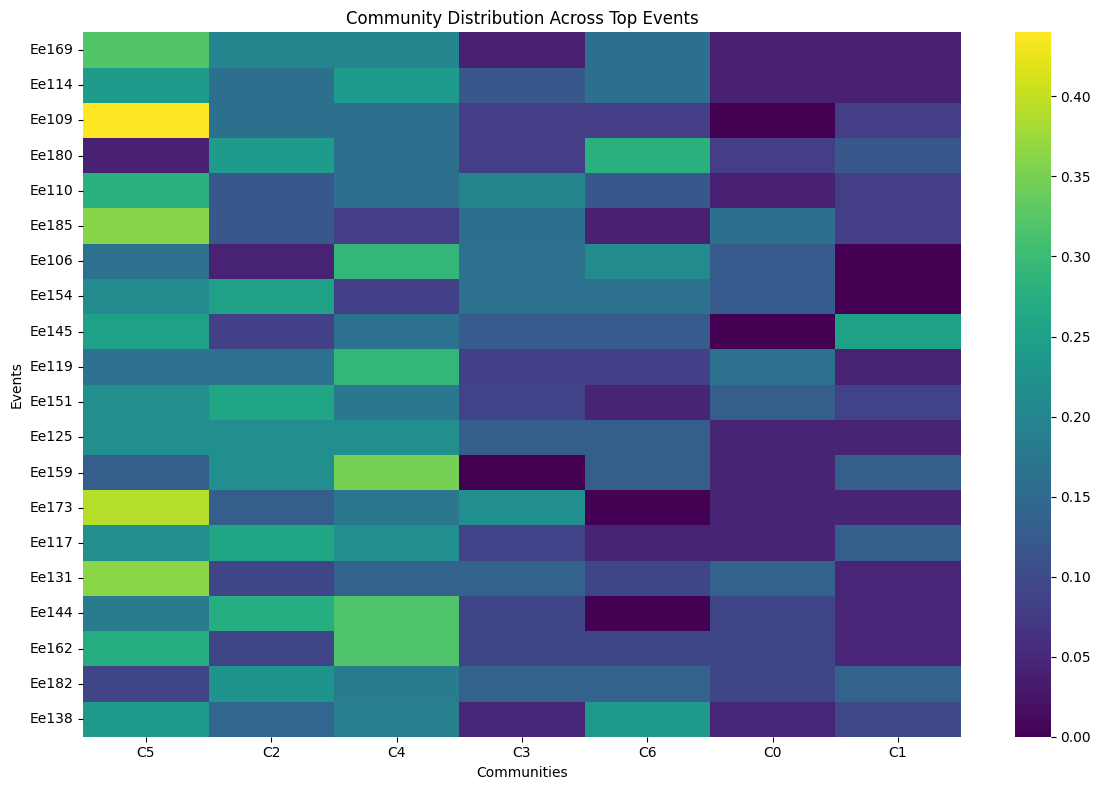

Visualizing top 5 events with most diverse communities...


C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\3076769564.py:204: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', max(len(community_ids), 1))


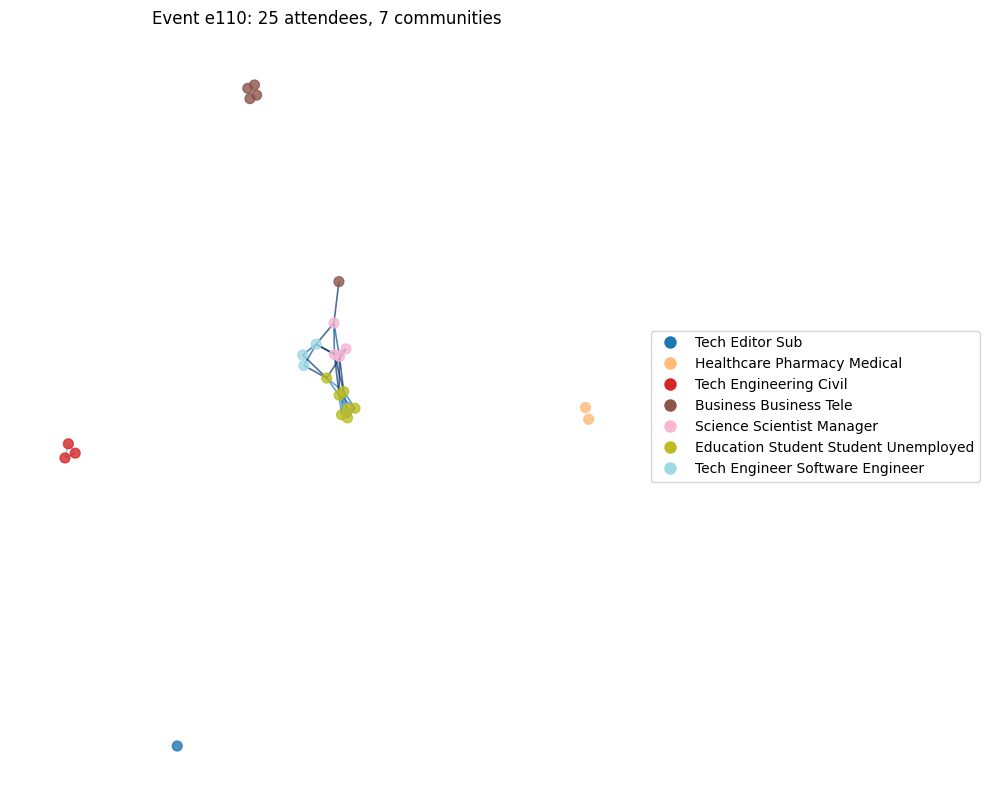


Community distribution for Event e110:
  Education Student Student Unemployed: 7 attendees
  Business Business Tele: 5 attendees
  Science Scientist Manager: 4 attendees
  Tech Engineer Software Engineer: 3 attendees
  Tech Engineering Civil: 3 attendees
  Healthcare Pharmacy Medical: 2 attendees
  Tech Editor Sub: 1 attendees

Centrality Analysis for e110 (ID: e110):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A343 from Education Student Student Unemployed (Score: 0.3333)
    #2: Attendee A629 from Education Student Student Unemployed (Score: 0.3333)
    #3: Attendee A777 from Science Scientist Manager (Score: 0.2500)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A343 from Education Student Student Unemployed (Score: 0.3889)
    #2: Attendee A629 from Education Student Student Unemployed (Score: 0.3889)
    #3: Attendee A777 from Science Scien

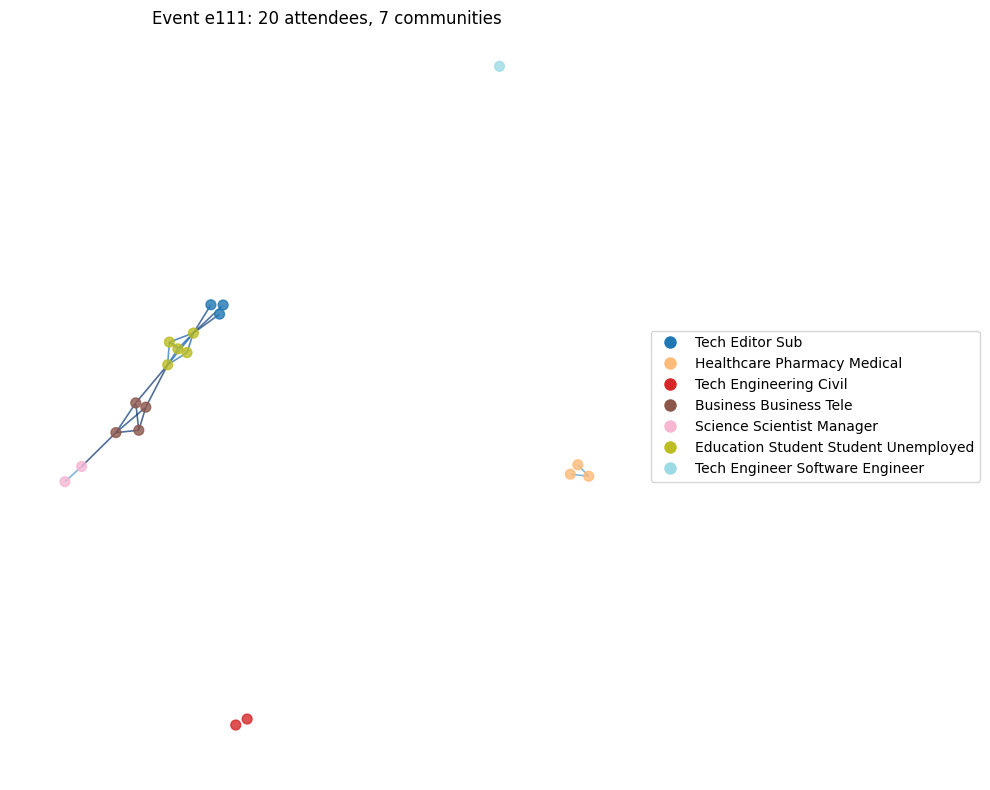


Community distribution for Event e111:
  Education Student Student Unemployed: 5 attendees
  Business Business Tele: 4 attendees
  Healthcare Pharmacy Medical: 3 attendees
  Tech Editor Sub: 3 attendees
  Science Scientist Manager: 2 attendees
  Tech Engineering Civil: 2 attendees
  Tech Engineer Software Engineer: 1 attendees

Centrality Analysis for e111 (ID: e111):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A259 from Education Student Student Unemployed (Score: 0.3684)
    #2: Attendee A854 from Education Student Student Unemployed (Score: 0.3158)
    #3: Attendee A272 from Education Student Student Unemployed (Score: 0.2105)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A854 from Education Student Student Unemployed (Score: 0.3867)
    #2: Attendee A259 from Education Student Student Unemployed (Score: 0.3421)
    #3: Attendee A737 from Bu

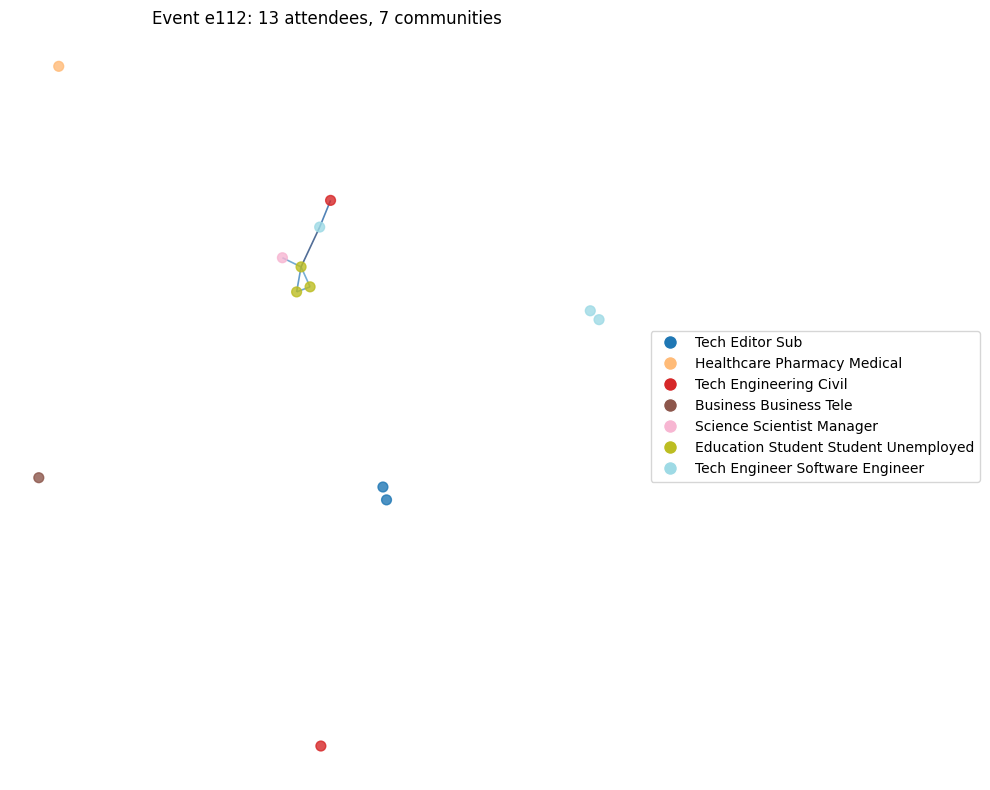


Community distribution for Event e112:
  Education Student Student Unemployed: 3 attendees
  Tech Engineer Software Engineer: 3 attendees
  Tech Editor Sub: 2 attendees
  Tech Engineering Civil: 2 attendees
  Healthcare Pharmacy Medical: 1 attendees
  Business Business Tele: 1 attendees
  Science Scientist Manager: 1 attendees

Centrality Analysis for e112 (ID: e112):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.3333)
    #2: Attendee A210 from Education Student Student Unemployed (Score: 0.1667)
    #3: Attendee A180 from Education Student Student Unemployed (Score: 0.1667)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.3472)
    #2: Attendee A288 from Tech Engineer Software Engineer (Score: 0.2604)
    #3: Attendee A210 from Educati

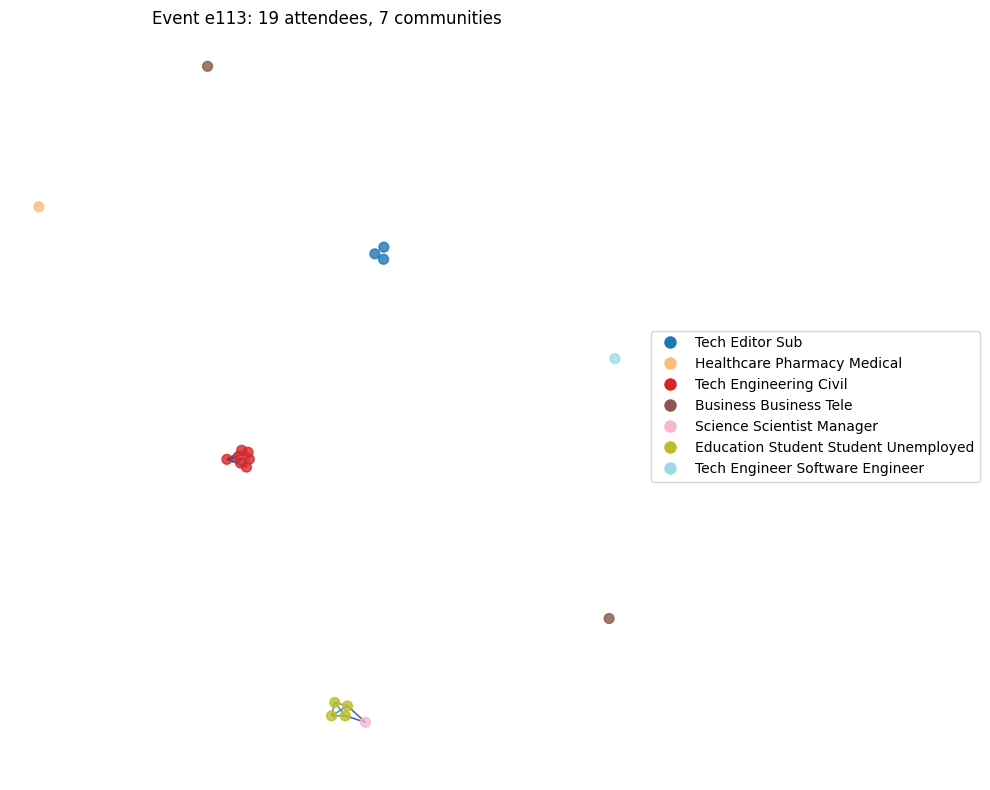


Community distribution for Event e113:
  Tech Engineering Civil: 7 attendees
  Education Student Student Unemployed: 4 attendees
  Tech Editor Sub: 3 attendees
  Business Business Tele: 2 attendees
  Science Scientist Manager: 1 attendees
  Tech Engineer Software Engineer: 1 attendees
  Healthcare Pharmacy Medical: 1 attendees

Centrality Analysis for e113 (ID: e113):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A18 from Tech Engineering Civil (Score: 0.3333)
    #2: Attendee A539 from Tech Engineering Civil (Score: 0.3333)
    #3: Attendee A934 from Tech Engineering Civil (Score: 0.3333)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A18 from Tech Engineering Civil (Score: 0.3333)
    #2: Attendee A539 from Tech Engineering Civil (Score: 0.3333)
    #3: Attendee A934 from Tech Engineering Civil (Score: 0.3333)

  Top Betweenness Centrality: (Mos

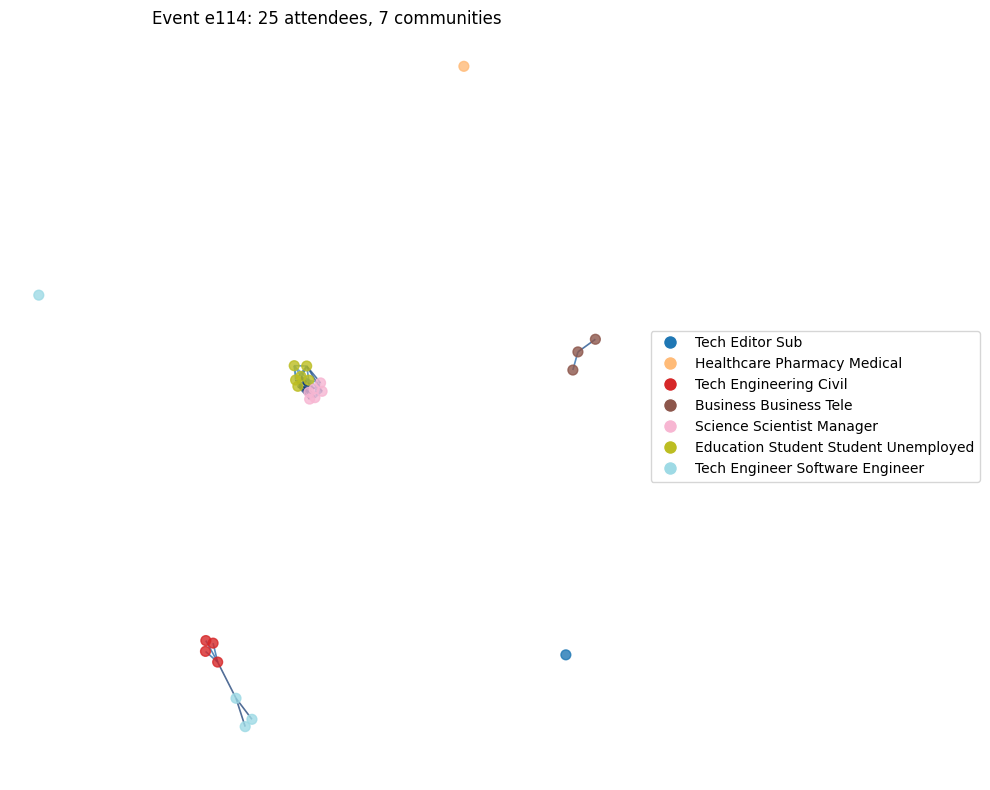


Community distribution for Event e114:
  Education Student Student Unemployed: 6 attendees
  Science Scientist Manager: 6 attendees
  Tech Engineering Civil: 4 attendees
  Tech Engineer Software Engineer: 4 attendees
  Business Business Tele: 3 attendees
  Tech Editor Sub: 1 attendees
  Healthcare Pharmacy Medical: 1 attendees

Centrality Analysis for e114 (ID: e114):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.4583)
    #2: Attendee A811 from Education Student Student Unemployed (Score: 0.3750)
    #3: Attendee A448 from Science Scientist Manager (Score: 0.3750)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.4583)
    #2: Attendee A811 from Education Student Student Unemployed (Score: 0.3878)
    #3: Attendee A448 from Science Scien

In [ ]:
"""
Attendee Community Detection - Part 4
-------------------------------------
This section extends our community detection to create event-specific community maps.

Key functions:
1. Load and process event-attendee pairings
2. Map attendees to their detected communities
3. Create event-specific subgraphs
4. Visualize community structure for each event
"""

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import seaborn as sns

def load_event_attendee_pairs(event_attendee_path):
    """
    Load event-attendee pairs data and preprocess it.
    
    Args:
        event_attendee_path (str): Path to event-attendee pairs CSV
        
    Returns:
        pd.DataFrame: Preprocessed event-attendee DataFrame
    """
    print(f"Loading event-attendee pairs from {event_attendee_path}")
    
    # Load data
    event_attendee_df = pd.read_csv(event_attendee_path)
    
    # Standardize column names
    event_attendee_df.columns = [col.strip().lower() for col in event_attendee_df.columns]
    
    # Map attendee IDs to match the format in attendees DataFrame
    if 'attendee_id' in event_attendee_df.columns:
        event_attendee_df['attendee_id_mapped'] = event_attendee_df['attendee_id'].str.upper()
    
    # Count unique events and attendees
    num_events = event_attendee_df['event_id'].nunique()
    num_attendees = event_attendee_df['attendee_id'].nunique()
    
    print(f"Found {num_events} unique events and {num_attendees} unique attendees")
    print(f"Total event-attendee pairs: {len(event_attendee_df)}")
    
    # Visualize event sizes (number of attendees per event)
    event_sizes = event_attendee_df.groupby('event_id').size().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(event_sizes)), event_sizes.values)
    plt.xlabel('Event Rank')
    plt.ylabel('Number of Attendees')
    plt.title('Event Size Distribution')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Display statistics for event sizes
    print(f"Event size statistics:")
    print(f"  Min: {event_sizes.min()} attendees")
    print(f"  Max: {event_sizes.max()} attendees")
    print(f"  Mean: {event_sizes.mean():.2f} attendees")
    print(f"  Median: {event_sizes.median()} attendees")
    
    return event_attendee_df

def create_event_attendee_mapping(attendees_df, event_attendee_df, communities):
    """
    Map attendees to communities and create event-specific mappings.
    
    Args:
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        event_attendee_df (pd.DataFrame): Event-attendee pairs DataFrame
        communities (dict): Mapping of node indices to community IDs
        
    Returns:
        dict: Event-specific community mappings
    """
    print("Creating event-attendee-community mappings...")
    
    # Create a mapping from A_ID to index (needed to map from attendee ID to node index)
    attendee_id_to_index = {row['A_ID']: i for i, row in attendees_df.iterrows()}
    
    # Create a mapping from attendee ID to community
    attendee_id_to_community = {}
    for node_idx, community_id in communities.items():
        if node_idx < len(attendees_df):
            attendee_id = attendees_df.iloc[node_idx]['A_ID']
            attendee_id_to_community[attendee_id] = community_id
    
    # Create event-specific mappings
    event_mapping = {}
    
    # For each event, identify the attendees and their communities
    for event_id in event_attendee_df['event_id'].unique():
        # Get attendees for this event
        event_attendees = event_attendee_df[event_attendee_df['event_id'] == event_id]
        
        # Map attendee IDs to communities
        attendee_communities = []
        for _, row in event_attendees.iterrows():
            attendee_id_mapped = row['attendee_id_mapped'] if 'attendee_id_mapped' in row else row['attendee_id'].upper()
            
            if attendee_id_mapped in attendee_id_to_community:
                community_id = attendee_id_to_community[attendee_id_mapped]
                attendee_communities.append((attendee_id_mapped, community_id))
        
        # Store mapping for this event
        event_mapping[event_id] = {
            'attendees': event_attendees['attendee_id'].tolist(),
            'attendee_communities': attendee_communities,
            'community_counts': Counter([comm for _, comm in attendee_communities])
        }
    
    # Print summary
    print(f"Created mappings for {len(event_mapping)} events")
    
    # Find events with most diverse community representation
    event_diversity = [(event_id, len(mapping['community_counts'])) 
                        for event_id, mapping in event_mapping.items()]
    
    event_diversity.sort(key=lambda x: x[1], reverse=True)
    
    print("Events with most diverse community representation:")
    for event_id, num_communities in event_diversity[:5]:
        print(f"  Event {event_id}: {num_communities} different communities")
    
    # Visualize community diversity across events
    diversity_counts = Counter([diversity for _, diversity in event_diversity])
    
    plt.figure(figsize=(10, 6))
    plt.bar(diversity_counts.keys(), diversity_counts.values())
    plt.xlabel('Number of Communities')
    plt.ylabel('Number of Events')
    plt.title('Community Diversity Across Events')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return event_mapping

def create_event_subgraphs(G, attendees_df, event_mapping):
    """
    Create subgraphs for each event based on the attendees.
    
    Args:
        G (networkx.Graph): Full attendee similarity graph
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        event_mapping (dict): Event-specific community mappings
        
    Returns:
        dict: Event-specific subgraphs
    """
    print("Creating event-specific subgraphs...")
    
    # Create a mapping from A_ID to index
    attendee_id_to_index = {row['A_ID']: i for i, row in attendees_df.iterrows()}
    
    # Create subgraphs for each event
    event_subgraphs = {}
    
    for event_id, mapping in event_mapping.items():
        # Get node indices for attendees in this event
        attendee_ids = [comm[0] for comm in mapping['attendee_communities']]
        node_indices = [attendee_id_to_index[aid] for aid in attendee_ids if aid in attendee_id_to_index]
        
        # Create subgraph
        if node_indices:
            subgraph = G.subgraph(node_indices)
            event_subgraphs[event_id] = subgraph
            print(f"Event {event_id}: {subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")
    
    return event_subgraphs

def visualize_event_community(event_id, subgraph, communities, community_labels=None, title=None, event_id_to_name=None):
    """
    Visualize communities for a specific event with descriptive labels.
    
    Args:
        event_id (str): Event ID
        subgraph (networkx.Graph): Subgraph for this event
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        title (str, optional): Custom title for the visualization
        event_id_to_name (dict, optional): Mapping from event_id to event name
    """
    # Skip if subgraph is empty
    if subgraph.number_of_nodes() == 0:
        print(f"Skipping visualization for Event {event_id}: No nodes in subgraph")
        return
    
    # Get event name if mapping is provided
    event_name = event_id_to_name.get(event_id, event_id) if event_id_to_name else event_id
    
    # Filter communities to only include nodes in the subgraph
    event_communities = {node: communities[node] for node in subgraph.nodes() if node in communities}
    
    # Get unique community IDs
    community_ids = sorted(set(event_communities.values()))
    
    # Create a colormap
    colormap = cm.get_cmap('tab20', max(len(community_ids), 1))
    
    # Map community IDs to colors
    color_map = {community_id: colormap(i % 20) for i, community_id in enumerate(community_ids)}
    
    # Assign colors to nodes based on their community
    node_colors = [color_map[event_communities[node]] for node in subgraph.nodes()]
    
    # Create spring layout with reduced k for tighter clustering
    pos = nx.spring_layout(subgraph, k=0.15, iterations=100, seed=42)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(
        subgraph, pos, 
        node_color=node_colors,
        node_size=50,
        alpha=0.8
    )
    
    # Draw edges with transparency based on weight if available
    if subgraph.number_of_edges() > 0 and 'weight' in next(iter(subgraph.edges(data=True)))[2]:
        edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]
        nx.draw_networkx_edges(
            subgraph, pos,
            width=1.2,
            alpha=0.7,
            edge_color=edge_weights,
            edge_cmap=plt.cm.Blues_r
        )
    else:
        nx.draw_networkx_edges(
            subgraph, pos,
            width=1.2,
            alpha=0.7,
            edge_color='navy'
        )
    
    # Add legend for communities if not too many
    if len(community_ids) <= 20:
        proxy_artists = []
        for comm_id in sorted(color_map.keys()):
            if community_labels and comm_id in community_labels:
                label = community_labels[comm_id]
            else:
                label = f"Community {comm_id}"
                
            proxy_artists.append(plt.Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor=color_map[comm_id], 
                               markersize=10, label=label))
        
        plt.legend(handles=proxy_artists, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set title using event name instead of just ID
    if title:
        plt.title(title)
    else:
        num_attendees = subgraph.number_of_nodes()
        num_communities = len(community_ids)
        plt.title(f"{event_name}: {num_attendees} attendees, {num_communities} communities")
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
        
def analyze_event_community_distribution(event_mapping):
    """
    Analyze and visualize the distribution of communities across events.
    
    Args:
        event_mapping (dict): Event-specific community mappings
    """
    print("Analyzing community distribution across events...")
    
    # Count communities in each event
    event_community_counts = {}
    all_communities = set()
    
    for event_id, mapping in event_mapping.items():
        community_counts = mapping['community_counts']
        event_community_counts[event_id] = community_counts
        all_communities.update(community_counts.keys())
    
    # Create a matrix of events vs communities
    all_communities = sorted(all_communities)
    events = sorted(event_mapping.keys())
    
    matrix = np.zeros((len(events), len(all_communities)))
    
    for i, event_id in enumerate(events):
        for j, community_id in enumerate(all_communities):
            matrix[i, j] = event_community_counts[event_id].get(community_id, 0)
    
    # Normalize by event size
    row_sums = matrix.sum(axis=1)
    matrix_normalized = matrix / row_sums[:, np.newaxis]
    
    # Create heatmap for top events and communities
    # Select top events and communities to make heatmap readable
    top_events_count = min(20, len(events))
    top_communities_count = min(20, len(all_communities))
    
    # Select top events (those with most attendees)
    top_events_indices = np.argsort(-matrix.sum(axis=1))[:top_events_count]
    top_events = [events[i] for i in top_events_indices]
    
    # Select top communities (those most represented across events)
    top_communities_indices = np.argsort(-matrix.sum(axis=0))[:top_communities_count]
    top_communities = [all_communities[i] for i in top_communities_indices]
    
    # Create submatrix for heatmap
    heatmap_matrix = matrix_normalized[np.ix_(top_events_indices, top_communities_indices)]
    
    # Visualize heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_matrix, cmap='viridis', 
                xticklabels=[f'C{c}' for c in top_communities],
                yticklabels=[f'E{e}' for e in top_events])
    plt.title('Community Distribution Across Top Events')
    plt.xlabel('Communities')
    plt.ylabel('Events')
    plt.tight_layout()
    plt.show()
    
    return matrix, matrix_normalized

def analyze_centrality_metrics(G, attendees_df, communities, community_labels=None):
    """
    Calculate various centrality metrics for each node in the graph
    and return the highest-scoring nodes for each metric.
    
    Args:
        G (networkx.Graph): The graph to analyze
        attendees_df (pd.DataFrame): DataFrame with attendee information
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        
    Returns:
        dict: Dictionary with centrality metrics and top nodes
    """
    print("Calculating centrality metrics...")
    
    # Create ID mapping from node index to attendee ID
    node_to_attendee = {}
    for i, row in attendees_df.iterrows():
        if i in G.nodes():
            node_to_attendee[i] = row['A_ID']
    
    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Eigenvector centrality may fail for disconnected graphs, so add error handling
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        print("Warning: Eigenvector centrality calculation failed. Setting to zeros.")
        eigenvector_centrality = {node: 0.0 for node in G.nodes()}
    
    # Katz centrality can also fail to converge, so add error handling
    try:
        katz_centrality = nx.katz_centrality(G, max_iter=1000)
    except:
        print("Warning: Katz centrality calculation failed. Using alternative approach.")
        try:
            # Use a smaller alpha value for better convergence
            katz_centrality = nx.katz_centrality(G, alpha=0.1, max_iter=5000)
        except:
            print("Warning: Katz centrality calculation still failed. Setting to zeros.")
            katz_centrality = {node: 0.0 for node in G.nodes()}
    
    # Find top nodes for each metric
    metrics = {
        'Degree Centrality': degree_centrality,
        'Closeness Centrality': closeness_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Eigenvector Centrality': eigenvector_centrality
        # 'Katz Centrality': katz_centrality
    }
    
    top_nodes = {}
    for metric_name, metric_values in metrics.items():
        # Sort nodes by metric value (descending)
        sorted_nodes = sorted(metric_values.items(), key=lambda x: x[1], reverse=True)
        
        # Get top 3 nodes
        top_3 = []
        for node_idx, value in sorted_nodes[:3]:
            # Get community and attendee ID
            community_id = communities.get(node_idx)
            if node_idx in node_to_attendee:
                attendee_id = node_to_attendee[node_idx]
                
                # Add community label if available
                if community_id is not None and community_labels and community_id in community_labels:
                    community_name = community_labels[community_id]
                else:
                    community_name = f"Community {community_id}" if community_id is not None else "Unknown"
                
                top_3.append({
                    'node_idx': node_idx,
                    'attendee_id': attendee_id,
                    'community_id': community_id,
                    'community_name': community_name,
                    'value': value
                })
        
        top_nodes[metric_name] = top_3
    
    return metrics, top_nodes

def analyze_event_centrality(event_id, subgraph, attendees_df, communities, community_labels=None, event_id_to_name=None):
    """
    Analyze centrality metrics for a specific event's subgraph.
    
    Args:
        event_id (str): Event ID
        subgraph (networkx.Graph): Subgraph for this event
        attendees_df (pd.DataFrame): DataFrame with attendee information
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        event_id_to_name (dict, optional): Mapping from event_id to event name
    """
    # Get event name if mapping is provided
    event_name = event_id_to_name.get(event_id, event_id) if event_id_to_name else event_id
    
    print(f"\nCentrality Analysis for {event_name} (ID: {event_id}):")
    
    # Skip if subgraph is too small
    if subgraph.number_of_nodes() < 3:
        print(f"  Too few nodes ({subgraph.number_of_nodes()}) for meaningful centrality analysis")
        return
    
    # Metric descriptions
    metric_descriptions = {
        'Degree Centrality': "Most direct connections to other attendees!",
        'Closeness Centrality': "Can reach everyone else in the network with the fewest steps!",
        'Betweenness Centrality': "Most crucial bridges connecting different groups of people!",
        'Eigenvector Centrality': "Connected to the most well-connected people!",
        'Katz Centrality': "Have the greatest overall influence throughout the entire network!"
    }
    
    # Calculate centrality metrics for this event's subgraph
    metrics, top_nodes = analyze_centrality_metrics(subgraph, attendees_df, communities, community_labels)
    
    # Print top nodes for each metric with descriptions
    for metric_name, nodes in top_nodes.items():
        description = metric_descriptions.get(metric_name, "")
        print(f"\n  Top {metric_name}: ({description})")
        for i, node in enumerate(nodes, 1):
            print(f"    #{i}: Attendee {node['attendee_id']} from {node['community_name']} (Score: {node['value']:.4f})")
                        
def visualize_top_event_communities(G, attendees_df, event_mapping, communities, community_labels=None, top_n=5):
    """
    Visualize community structures for the top events with most diverse community representation
    and analyze centrality metrics.
    
    Args:
        G (networkx.Graph): Full attendee similarity graph
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        event_mapping (dict): Event-specific community mappings
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        top_n (int): Number of top events to visualize
    """
    print(f"Visualizing top {top_n} events with most diverse communities...")
    
    # Create a mapping from A_ID to index
    attendee_id_to_index = {row['A_ID']: i for i, row in attendees_df.iterrows()}
    
    # Find events with most diverse community representation
    event_diversity = [(event_id, len(mapping['community_counts'])) 
                        for event_id, mapping in event_mapping.items()]
    
    event_diversity.sort(key=lambda x: x[1], reverse=True)
    
    # Create subgraphs and visualize top events
    for event_id, num_communities in event_diversity[:top_n]:
        # Get node indices for attendees in this event
        attendee_ids = [comm[0] for comm in event_mapping[event_id]['attendee_communities']]
        node_indices = [attendee_id_to_index[aid] for aid in attendee_ids if aid in attendee_id_to_index]
        
        # Create subgraph
        if node_indices:
            subgraph = G.subgraph(node_indices)
            
            # Skip if too few nodes
            if subgraph.number_of_nodes() < 3:
                print(f"Skipping Event {event_id}: Too few nodes ({subgraph.number_of_nodes()}) in subgraph")
                continue
            
            title = f"Event {event_id}: {subgraph.number_of_nodes()} attendees, {num_communities} communities"
            
            # Visualize community structure
            visualize_event_community(event_id, subgraph, communities, community_labels, title)
            
            # Print community distribution
            community_counts = event_mapping[event_id]['community_counts']
            print(f"\nCommunity distribution for Event {event_id}:")
            for comm_id, count in sorted(community_counts.items(), key=lambda x: x[1], reverse=True):
                if community_labels and comm_id in community_labels:
                    comm_label = community_labels[comm_id]
                    print(f"  {comm_label}: {count} attendees")
                else:
                    print(f"  Community {comm_id}: {count} attendees")
            
            # Analyze centrality metrics for this event
            analyze_event_centrality(event_id, subgraph, attendees_df, communities, community_labels)

# 1. Load event-attendee pairs
event_attendee_df = load_event_attendee_pairs('event_attendee_pairs_future.csv')

# 2. Create event-attendee-community mappings
event_mapping = create_event_attendee_mapping(processed_df, event_attendee_df, communities)

# 3. Create event-specific subgraphs
event_subgraphs = create_event_subgraphs(G, processed_df, event_mapping)

# 4. Analyze community distribution across events
comm_matrix, comm_matrix_norm = analyze_event_community_distribution(event_mapping)

# 5. Visualize top events with most diverse community representation
# Note: Now includes centrality analysis
visualize_top_event_communities(G, processed_df, event_mapping, communities, community_labels, top_n=5)

# # 6. If you want to analyze centrality metrics for the entire graph:
# print("\nCentrality Analysis for the entire attendee network:")
# all_metrics, all_top_nodes = analyze_centrality_metrics(G, processed_df, communities, community_labels)
# for metric_name, nodes in all_top_nodes.items():
#     print(f"\n  Top {metric_name}:")
#     for i, node in enumerate(nodes, 1):
#         print(f"    #{i}: Attendee {node['attendee_id']} from {node['community_name']} (Score: {node['value']:.4f})")

In [56]:
def generate_centrality_csv(attendees_df, event_attendee_df, event_mapping, communities, community_labels=None, output_path='attendee_centrality_metrics.csv'):
    """
    Generate a CSV file that combines the original attendee data with
    centrality metrics for each attendee across events.
    
    Args:
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        event_attendee_df (pd.DataFrame): Event-attendee pairs DataFrame
        event_mapping (dict): Event-specific community mappings
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        output_path (str): Path to save the CSV file
    """
    print(f"Generating centrality metrics CSV...")
    
    # Create a mapping from A_ID to index
    attendee_id_to_index = {row['A_ID']: i for i, row in attendees_df.iterrows()}
    index_to_attendee_id = {i: row['A_ID'] for i, row in attendees_df.iterrows() if i in attendee_id_to_index.values()}
    
    # Create a copy of the attendees DataFrame
    result_df = attendees_df.copy()
    
    # Add community information
    result_df['community_id'] = result_df.index.map(lambda idx: communities.get(idx, None))
    
    # Add community label if available
    if community_labels:
        result_df['community_label'] = result_df['community_id'].map(
            lambda c_id: community_labels.get(c_id, f"Community {c_id}") if c_id is not None else None
        )
    
    # Create a dictionary to store centrality metrics for each attendee and event
    centrality_metrics = defaultdict(lambda: defaultdict(dict))
    
    # Process each event
    for event_id in event_attendee_df['event_id'].unique():
        # Get attendees for this event
        event_attendees = event_attendee_df[event_attendee_df['event_id'] == event_id]
        attendee_id_mapped = event_attendees['attendee_id_mapped'].tolist()
        
        # Get node indices for attendees in this event
        node_indices = [attendee_id_to_index[aid] for aid in attendee_id_mapped if aid in attendee_id_to_index]
        
        # Skip if too few nodes
        if len(node_indices) < 3:
            print(f"Skipping Event {event_id} centrality calculation: Too few nodes ({len(node_indices)})")
            continue
        
        # Create subgraph
        G = nx.Graph()
        G.add_nodes_from(node_indices)
        
        # Add edges based on the original graph connections
        for i in node_indices:
            for j in node_indices:
                if i < j and attendees_df is not None:
                    # Calculate similarity or check if there's a connection
                    # For simplicity, we'll just check if they're in the same community
                    if communities.get(i) == communities.get(j):
                        G.add_edge(i, j, weight=1.0)
        
        # Skip if graph has no edges
        if G.number_of_edges() == 0:
            print(f"Skipping Event {event_id} centrality calculation: No edges in subgraph")
            continue
        
        # Calculate centrality metrics
        try:
            degree_cent = nx.degree_centrality(G)
            closeness_cent = nx.closeness_centrality(G)
            betweenness_cent = nx.betweenness_centrality(G)
            eigenvector_cent = nx.eigenvector_centrality(G, max_iter=1000)
            katz_cent = nx.katz_centrality(G, max_iter=1000)
            
            # Store metrics for each attendee
            for node_idx in G.nodes():
                attendee_id = index_to_attendee_id[node_idx]
                centrality_metrics[attendee_id][event_id] = {
                    'degree': degree_cent.get(node_idx, 0),
                    'closeness': closeness_cent.get(node_idx, 0),
                    'betweenness': betweenness_cent.get(node_idx, 0),
                    'eigenvector': eigenvector_cent.get(node_idx, 0),
                    'katz': katz_cent.get(node_idx, 0)
                }
        except Exception as e:
            print(f"Error calculating centrality for Event {event_id}: {e}")
            continue
    
    # Add event participation and centrality metrics to the result DataFrame
    event_ids = sorted(event_attendee_df['event_id'].unique())
    
    # First, add event participation columns
    for event_id in event_ids:
        event_attendees = set(event_attendee_df[event_attendee_df['event_id'] == event_id]['attendee_id_mapped'].tolist())
        result_df[f'attended_{event_id}'] = result_df['A_ID'].apply(lambda x: x in event_attendees)
    
    # Then, add centrality metrics for each event
    for metric in ['degree', 'closeness', 'betweenness', 'eigenvector', 'katz']:
        for event_id in event_ids:
            col_name = f'{event_id}_{metric}_centrality'
            result_df[col_name] = result_df['A_ID'].apply(
                lambda aid: centrality_metrics[aid][event_id].get(metric, None) if aid in centrality_metrics and event_id in centrality_metrics[aid] else None
            )
    
    # Save to CSV
    result_df.to_csv(output_path, index=False)
    print(f"Centrality metrics saved to {output_path}")
    
    return result_df

In [57]:
# Calculate and save centrality metrics for all attendees across events
centrality_df = generate_centrality_csv(
    attendees_df=processed_df,
    event_attendee_df=event_attendee_df,
    event_mapping=event_mapping,
    communities=communities,
    community_labels=community_labels,
    output_path='attendee_centrality_metrics.csv'
)

Generating centrality metrics CSV...
Skipping Event e102 centrality calculation: Too few nodes (1)
Skipping Event e104 centrality calculation: Too few nodes (2)
Error calculating centrality for Event e109: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 1000 iterations')
Skipping Event e137 centrality calculation: Too few nodes (1)
Skipping Event e140 centrality calculation: Too few nodes (1)
Skipping Event e149 centrality calculation: No edges in subgraph
Skipping Event e156 centrality calculation: No edges in subgraph
Skipping Event e160 centrality calculation: Too few nodes (1)
Skipping Event e168 centrality calculation: Too few nodes (1)
Skipping Event e183 centrality calculation: Too few nodes (2)
Skipping Event e190 centrality calculation: Too few nodes (1)
Skipping Event e191 centrality calculation: Too few nodes (1)
Skipping Event e192 centrality calculation: Too few nodes (2)


C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\2249392805.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'attended_{event_id}'] = result_df['A_ID'].apply(lambda x: x in event_attendees)
C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\2249392805.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'attended_{event_id}'] = result_df['A_ID'].apply(lambda x: x in event_attendees)
C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\2249392805.py:95: PerformanceWarning: DataFrame is highly fragmented.  T

Centrality metrics saved to attendee_centrality_metrics.csv


In [58]:
def visualize_specific_event(event_id, G, attendees_df, event_mapping, communities, community_labels=None, event_id_to_name=None):
    """
    Visualize and analyze a specific event by its ID.
    
    Args:
        event_id (str): ID of the event to visualize
        G (networkx.Graph): Full attendee similarity graph
        attendees_df (pd.DataFrame): Preprocessed attendees DataFrame
        event_mapping (dict): Event-specific community mappings
        communities (dict): Mapping of node indices to community IDs
        community_labels (dict, optional): Mapping of community IDs to descriptive labels
        event_id_to_name (dict, optional): Mapping from event_id to event name
        
    Returns:
        networkx.Graph: Subgraph for the specified event
    """
    # Check if the event exists
    if event_id not in event_mapping:
        print(f"Event {event_id} not found in event mappings.")
        return None
    
    # Get event name if mapping is provided
    event_name = event_id_to_name.get(event_id, event_id) if event_id_to_name else event_id
    
    # Create a mapping from A_ID to index
    attendee_id_to_index = {row['A_ID']: i for i, row in attendees_df.iterrows()}
    
    # Get node indices for attendees in this event
    attendee_ids = [comm[0] for comm in event_mapping[event_id]['attendee_communities']]
    node_indices = [attendee_id_to_index[aid] for aid in attendee_ids if aid in attendee_id_to_index]
    
    # Create subgraph
    if len(node_indices) == 0:
        print(f"No valid attendees found for Event {event_id} ({event_name}).")
        return None
        
    subgraph = G.subgraph(node_indices)
    
    # Skip if too few nodes
    if subgraph.number_of_nodes() < 3:
        print(f"Event {event_id} ({event_name}) has too few nodes ({subgraph.number_of_nodes()}) for meaningful visualization.")
        return subgraph
    
    # Get the number of communities in this event
    num_communities = len(event_mapping[event_id]['community_counts'])
    
    # Create title using event name
    title = f"{event_name}: {subgraph.number_of_nodes()} attendees, {num_communities} communities"
    
    # Visualize community structure
    visualize_event_community(event_id, subgraph, communities, community_labels, title, event_id_to_name)
    
    # Print community distribution
    community_counts = event_mapping[event_id]['community_counts']
    print(f"\nCommunity distribution for {event_name} (ID: {event_id}):")
    for comm_id, count in sorted(community_counts.items(), key=lambda x: x[1], reverse=True):
        if community_labels and comm_id in community_labels:
            comm_label = community_labels[comm_id]
            print(f"  {comm_label}: {count} attendees")
        else:
            print(f"  Community {comm_id}: {count} attendees")
    
    # Analyze centrality metrics for this event
    analyze_event_centrality(event_id, subgraph, attendees_df, communities, community_labels, event_id_to_name)
    
    return subgraph


=== Analyzing Event e133 ===


C:\Users\Artur\AppData\Local\Temp\ipykernel_19108\3076769564.py:204: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', max(len(community_ids), 1))


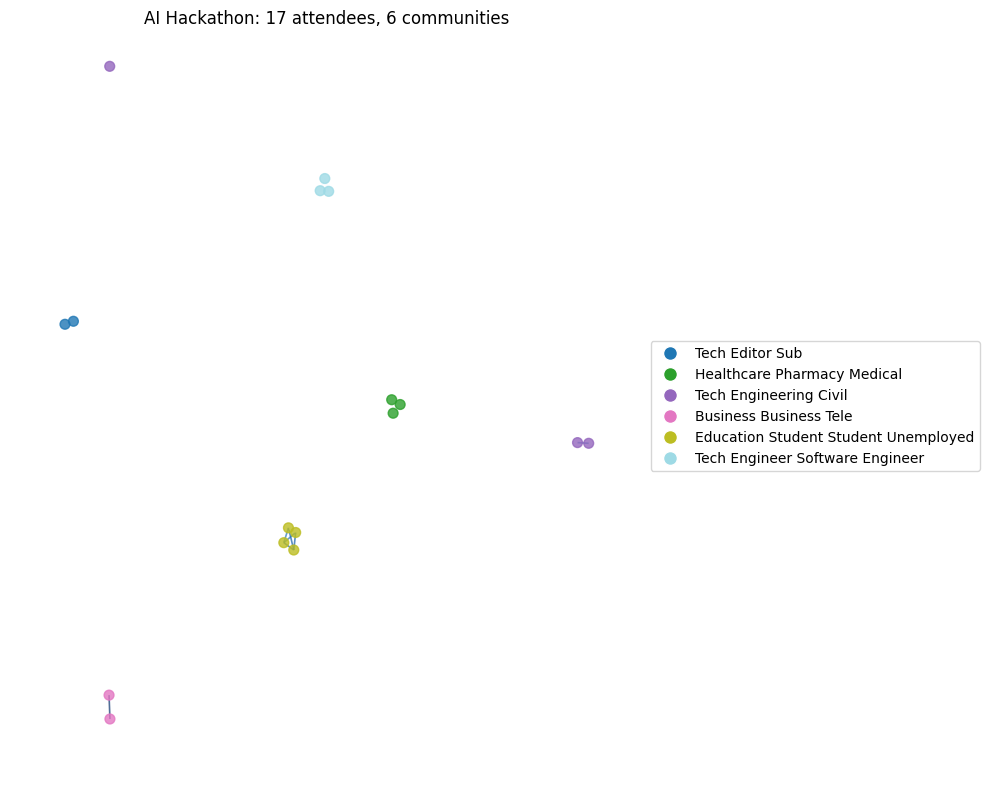


Community distribution for AI Hackathon (ID: e133):
  Education Student Student Unemployed: 4 attendees
  Tech Engineering Civil: 3 attendees
  Tech Engineer Software Engineer: 3 attendees
  Healthcare Pharmacy Medical: 3 attendees
  Tech Editor Sub: 2 attendees
  Business Business Tele: 2 attendees

Centrality Analysis for AI Hackathon (ID: e133):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A677 from Education Student Student Unemployed (Score: 0.1875)
    #2: Attendee A488 from Education Student Student Unemployed (Score: 0.1875)
    #3: Attendee A884 from Education Student Student Unemployed (Score: 0.1875)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A677 from Education Student Student Unemployed (Score: 0.1875)
    #2: Attendee A488 from Education Student Student Unemployed (Score: 0.1875)
    #3: Attendee A884 from Education Student Stud

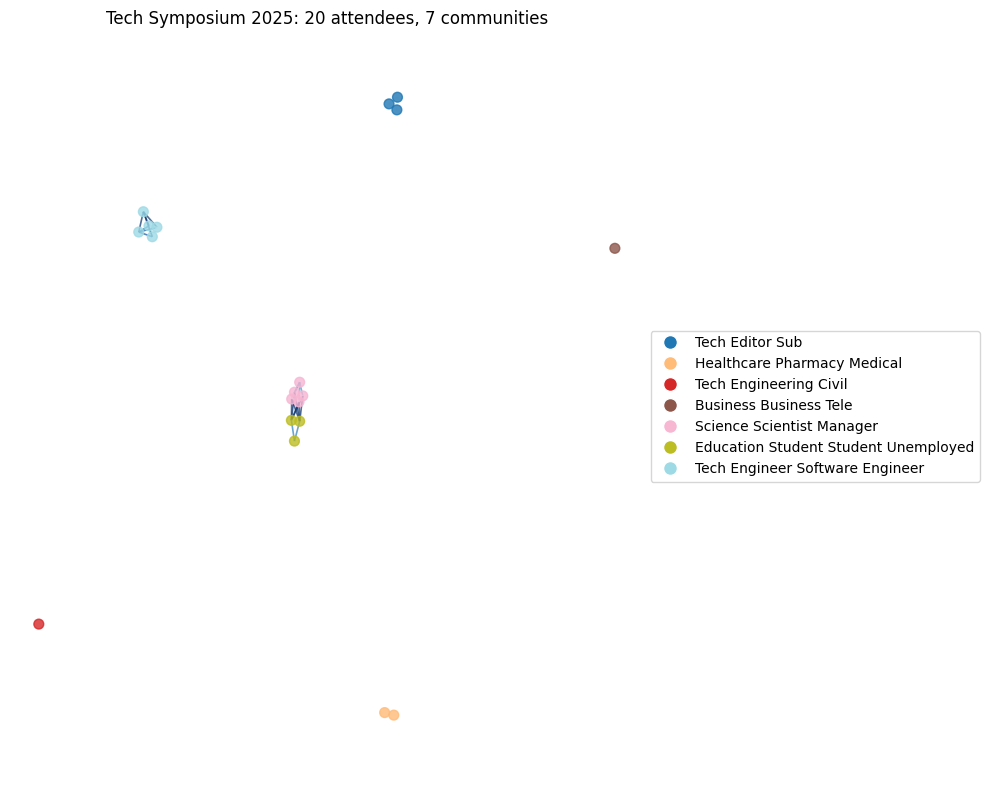


Community distribution for Tech Symposium 2025 (ID: e189):
  Science Scientist Manager: 5 attendees
  Tech Engineer Software Engineer: 5 attendees
  Tech Editor Sub: 3 attendees
  Education Student Student Unemployed: 3 attendees
  Healthcare Pharmacy Medical: 2 attendees
  Business Business Tele: 1 attendees
  Tech Engineering Civil: 1 attendees

Centrality Analysis for Tech Symposium 2025 (ID: e189):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A149 from Education Student Student Unemployed (Score: 0.3158)
    #2: Attendee A30 from Science Scientist Manager (Score: 0.3158)
    #3: Attendee A426 from Science Scientist Manager (Score: 0.3158)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A149 from Education Student Student Unemployed (Score: 0.3224)
    #2: Attendee A30 from Science Scientist Manager (Score: 0.3224)
    #3: Attendee A426 from Sc

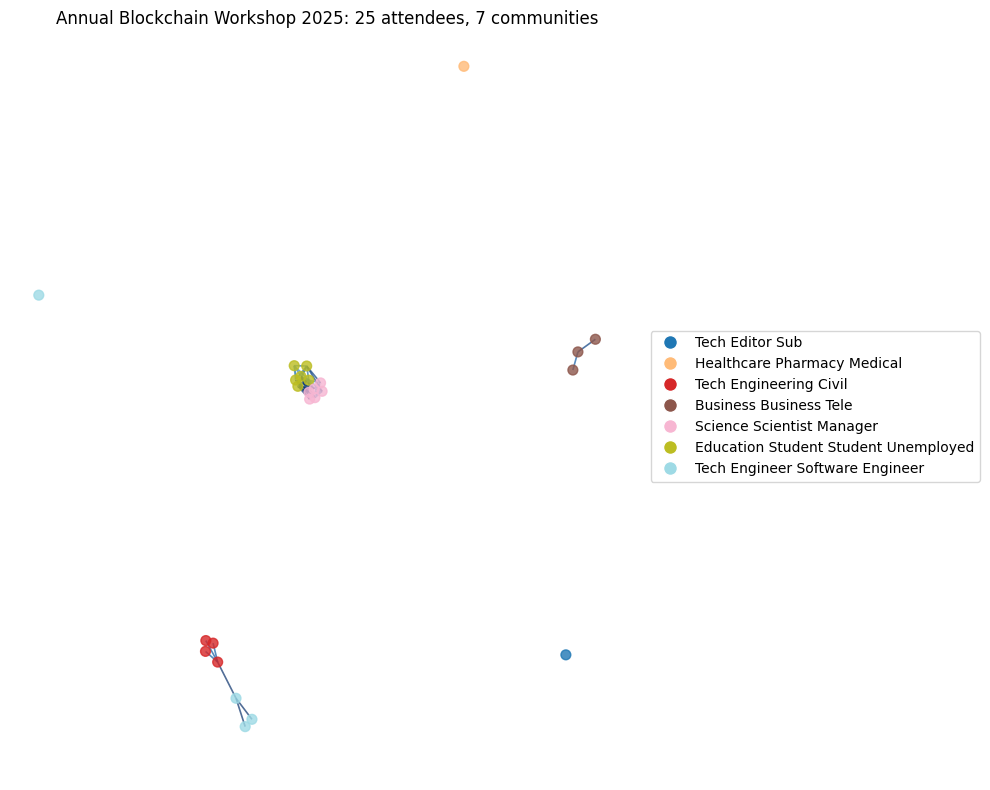


Community distribution for Annual Blockchain Workshop 2025 (ID: e114):
  Education Student Student Unemployed: 6 attendees
  Science Scientist Manager: 6 attendees
  Tech Engineering Civil: 4 attendees
  Tech Engineer Software Engineer: 4 attendees
  Business Business Tele: 3 attendees
  Tech Editor Sub: 1 attendees
  Healthcare Pharmacy Medical: 1 attendees

Centrality Analysis for Annual Blockchain Workshop 2025 (ID: e114):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.4583)
    #2: Attendee A811 from Education Student Student Unemployed (Score: 0.3750)
    #3: Attendee A448 from Science Scientist Manager (Score: 0.3750)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A386 from Education Student Student Unemployed (Score: 0.4583)
    #2: Attendee A811 from Education Student Student Unemploy

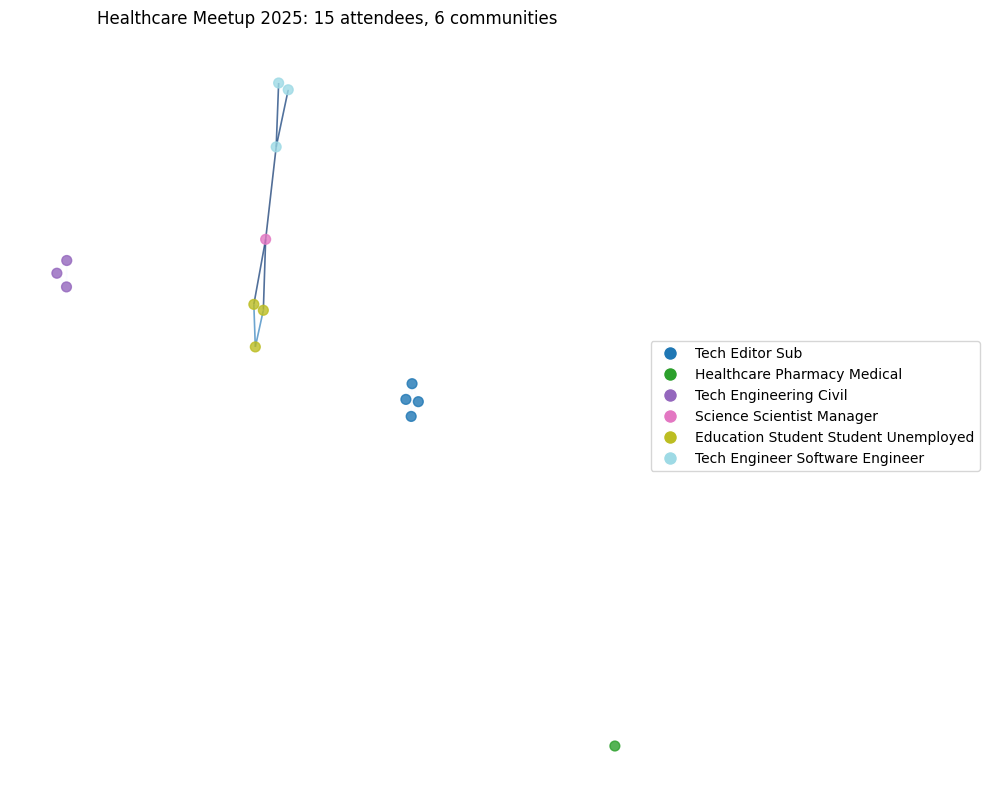


Community distribution for Healthcare Meetup 2025 (ID: e122):
  Tech Editor Sub: 4 attendees
  Tech Engineering Civil: 3 attendees
  Education Student Student Unemployed: 3 attendees
  Tech Engineer Software Engineer: 3 attendees
  Healthcare Pharmacy Medical: 1 attendees
  Science Scientist Manager: 1 attendees

Centrality Analysis for Healthcare Meetup 2025 (ID: e122):
Calculating centrality metrics...

  Top Degree Centrality: (Most direct connections to other attendees!)
    #1: Attendee A14 from Tech Editor Sub (Score: 0.2143)
    #2: Attendee A142 from Science Scientist Manager (Score: 0.2143)
    #3: Attendee A914 from Education Student Student Unemployed (Score: 0.2143)

  Top Closeness Centrality: (Can reach everyone else in the network with the fewest steps!)
    #1: Attendee A142 from Science Scientist Manager (Score: 0.2857)
    #2: Attendee A275 from Tech Engineer Software Engineer (Score: 0.2571)
    #3: Attendee A914 from Education Student Student Unemployed (Score: 0.2

In [61]:
# Example of visualizing specific events by ID
specific_event_ids = ['e133','e189','e114','e75','e122','e98','e9','e70','e11']  # Replace with your event IDs of interest
for event_id in specific_event_ids:
    print(f"\n=== Analyzing Event {event_id} ===")
    event_subgraph = visualize_specific_event(
        event_id=event_id,
        G=G,
        attendees_df=processed_df,
        event_mapping=event_mapping,
        communities=communities,
        community_labels=community_labels,
        event_id_to_name=event_id_to_name
    )